In [93]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pybloom import BloomFilter
import inspect
import matplotlib.font_manager
from sklearn import svm
import os
import glob
import pickle as pkl
import time
%matplotlib notebook
from itertools import product
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

In [64]:
from sklearn import preprocessing
import numpy as np
import sys
from sklearn.metrics import accuracy_score
import pickle
from sklearn import mixture
import math

def ngram(X, gramsize):
    numele = len(X)
    minlen = len(X[0])
    maxlen = len(X[0])
    
    for i in X:
        templen = len(i)
        if(templen>maxlen):
            maxlen=templen
        if(templen<minlen):
            minlen=templen
    reqdim = maxlen - gramsize +1
    
    Y = []
    for i in X:
        tempy = []
        paddedi = i + "0"*(maxlen-len(i))
        for j in range(0,len(paddedi)-gramsize+1):
            tempy.append(paddedi[j:j+gramsize])
        if len(tempy) == 0:
            tempy = [paddedi]
        templeny = len(tempy)
        
        Y.append(tempy)
    return Y

def ngramEnforce(X, gramsize, reqdim):
    numele = len(X)
    minlen = len(X[0])
    maxlen = len(X[0])
    for i in X:
        templen = len(i)
        if(templen>maxlen):
            maxlen=templen
        if(templen<minlen):
            minlen=templen
    maxlen = reqdim + gramsize -1
    Y = []
    for i in X:
        tempy = []
        paddedi = i + "0"*(maxlen-len(i))
        for j in range(0,len(paddedi)-gramsize+1):
            tempy.append(paddedi[j:j+gramsize])
        templeny = len(tempy)
        
        Y.append(tempy)
    return np.array(Y)

def rstripfn(x):
    x = x.rstrip('\n')
    
    return x.rstrip('\n')

def getDataInString(filename):
    with open(filename) as f1:
        lst1 = map(rstripfn,f1.readlines())
    return lst1

def findngram(gramsize, lst1):
    lst1g = ngram(lst1, gramsize)

    reqdim = len(lst1g[0])
    lst1f = []
    for i in lst1g:
        lst1f.append(map(float, i))

    nplst1 = np.array(lst1f)
    return (nplst1,reqdim)

def preprocess_train(nplst1):
    lstf1 = nplst1.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    lstS1 = min_max_scaler.fit_transform(lstf1)
    return lstS1, min_max_scaler

def preprocess_test(nplst1, min_max_scaler):
    lstf1 = nplst1.astype(float)
    lstS1 = min_max_scaler.transform(lstf1)
    return lstS1

def trainfn(lstS1, n_compo, maxiter):
    clf = mixture.GaussianMixture(n_components=n_compo, covariance_type='full', max_iter=maxiter)
    clf.fit(lstS1)
    return clf

def findmeansigma(clf, lstS1):
    meanscore = np.mean(clf.score_samples(lstS1))
    meanvar = np.var(clf.score_samples(lstS1))
    sigma = math.sqrt(meanvar)
    return (meanscore, sigma)

def mypred(X, clf, mean, sigma):
    scores = clf.score_samples(X)
    print(scores)
    predictions = []
    for i in scores:
        print("diff is ",abs(i-mean))
        if(abs(i-mean)<=max(thres*sigma, 1.0/1e12)):
            predictions.append(1)
        else:
            predictions.append(-1)
    return predictions
def mypredSvm(X, clf):
    scores = clf.predict(X)
    return clf.predict(X)

def calcncompo(n):
    if(n>10000):
        return 100
    elif(n<60):
        return max(1, n/10)
    else:
        return 9

def areAllNumeric(l):
    l1 = map(isCharacterAscii, l)
    return all(l1)

def isCharacterAscii(str):
    try:
        float(str)
        return True
    except ValueError:
        return False

def train(filename, sstableID):
    lst1 = getDataInString(filename)
    if(not areAllNumeric(lst1)):
        print("returning cause key is not numeric")
        return
    if(len(lst1) == 1):
        print('returning cause num key is 1')
        return
    nplst1, reqdim = findngram(gramsize, lst1)
    lstS1, min_max_scaler = preprocess_train(nplst1)
    n_compo = calcncompo(len(lst1))
    clf = trainfn(lstS1, n_compo, maxiter)
    mean, sigma = findmeansigma(clf, lstS1)
    models[str(sstableID)] = (clf, mean, sigma, reqdim, min_max_scaler)
    print('training done with sstableid - ', sstableID)
    return

def trainIndi(nplst1, sstableID,n_compo):
#     lst1 = getDataInString(filename)
#     if(not areAllNumeric(lst1)):
#         print("returning cause key is not numeric")
#         return
#     if(len(lst1) == 1):
#         print('returning cause num key is 1')
#         return
#     nplst1, reqdim = findngram(gramsize, lst1)
#     print("prev mean was ", np.mean(nplst1.transpose()))
#     print("prev var was ", np.var(nplst1.transpose()))
#     lstS1, min_max_scaler = preprocess_train(nplst1)
    print("passed mean was ",np.mean(nplst1.transpose()))
    print("passed sigma was ",np.var(nplst1.transpose()))
#     n_compo = calcncompo(len(lst1))
    clf = trainfn(nplst1, n_compo, maxiter)
    print("found means ")
    print(np.sort(clf.means_.transpose()[0]))
    print("cov matrix ")
    print(clf.covariances_)
    print("weights :")
    print(clf.weights_)
    mean, sigma = findmeansigma(clf, nplst1)
    print("mean is ",str(mean))
    print("sigma is ", str(sigma))
    reqdim = len(nplst1[0])
    models[str(sstableID)] = (clf, mean, sigma, reqdim)
    print('training done with sstableid - ', sstableID)
    return

def trainIndiSvm(nplst1, sstableID, nu, gamma, models):
    print("passed mean was ",np.mean(nplst1, axis=0))
    print("passed sigma was ",np.var(nplst1, axis=0))
    clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
    clf.fit(nplst1)
    reqdim = len(nplst1[0])
#     print("reqdim is ",reqdim)
    models[str(sstableID)] = (clf, reqdim)
    print('training done with sstableid - ', sstableID)
    return models
def trainIndiSvmTol(nplst1, sstableID, nu, gamma, models,tol):
    print("passed mean was ",np.mean(nplst1, axis=0))
    print("passed sigma was ",np.var(nplst1, axis=0))
    clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma, tol=tol)
    clf.fit(nplst1)
    reqdim = len(nplst1[0])
#     print("reqdim is ",reqdim)
    models[str(sstableID)] = (clf, reqdim)
    print('training done with sstableid - ', sstableID)
    return models
def test(keyPredstr, sstableID):
    if(keyPredstr == ''):
        print('returning cause string is empty')
        return 0
    if(not isCharacterAscii(keyPredstr)):
        print('returning cause not numric')
        return 0
    keyPred = [str(keyPredstr)]
    if sstableID in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim, min_max_scaler = models[str(sstableID)]
        keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
        keyPredS = preprocess_test(keyPredg, min_max_scaler)
        prediction = mypred(keyPredS, clf, mean, sigma)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0

    
def testIndi(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypred([keyPredg], clf, mean, sigma)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def testIndiSvm(keyPredg, sstableID, models):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypredSvm([keyPredg], clf)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0

def testIndi2(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypred(keyPredg, clf, mean, sigma)
        return prediction
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def testIndiSvm2(keyPredg, sstableID, models):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypredSvm(keyPredg, clf)
        return prediction
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def sizeofmodels():
    l = []
    for sstableID in models:
        clf, mean, sigma, reqdim, min_max_scaler = models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
def sumsizeofmodels(models):
    agg =0
    for sstableID in models:
        clf, mean, sigma, reqdim= models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        agg += tempsize
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
    return agg
def sumsizeofmodelssvm(models):
    agg =0
    for sstableID in models:
        clf, reqdim= models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        agg += tempsize
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
    return agg
def sumsizeofmodelssvmReal(models):
    agg =0
    for sstableID in models:
        tempmodel, reqdim= models[str(sstableID)]
        tempsize = 8*(tempmodel.support_vectors_.shape[0]*tempmodel.support_vectors_.shape[1])+ 8*(tempmodel.dual_coef_.shape[0]*tempmodel.dual_coef_.shape[1]) + 4*(tempmodel.support_.shape[0])
        agg += tempsize
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, tempsize)
    return agg
def sumsizeofbloom(bloomfilters):
    agg =0
    for f in bloomfilters.values():
        agg += f.num_bits
    agg = agg/8
    return agg

def readFileByLines(filename):
    f = open(filename, 'r')
    lst = f.readlines()
    f.close()
#     print(lst)
#     lst = map(str.rstrip, lst)
    return lst
def parseVdisk(lst):
    lst = [s.split(':') for s in lst]
#     vid = []
#     blc = [] 
    mat = []
    for ele in lst:
#         vid.append(int(ele[1]))
#         blc.append(int(ele[2], 16))
        mat.append([float(int(ele[1]))/1e0,float(int(ele[2], 16))/1e0])
#     print(vid, blc)
#     return (vid, blc)
    return mat


In [65]:
def getData():
    foldername = "metadata_maps/vdisk/*.db"
    files = sorted(glob.glob(foldername))
    ctr=0
    alltemptableData = []
    for fle in files:
        thisline = readFileByLines(fle)
    #     if(len(thisline)>1000):
    #         continue
        mat = parseVdisk(thisline)
        ssTableData[ctr] = np.array(mat).reshape(-1,2)
        ctr+=1
        alltemptableData+=mat
        print(ctr,len(thisline))
    # print(lines)
    alltemptableData = np.array(alltemptableData).reshape(-1,2)
    return (ssTableData, alltemptableData)

In [66]:
def getScalers():
    scalers = {}
    for i in range(0,len(ssTableData)):
        thistableData = ssTableData[i]
        scaler = preprocessing.StandardScaler().fit(thistableData)
        scalers[i] = scaler
    return scalers

In [67]:
# Generate the data
# alltemptableData = generateGaussArrTwoDim(
#     numclustersPerSStable*numSstable, gapBetweenClusters, clusterSigma, numelePerCluster )
# np.random.shuffle(alltemptableData)


In [68]:
# for i in range(0,len(ssTableData)):
#     thistableData = alltemptableData[i*numclustersPerSStable:(i+1)*numclustersPerSStable]
#     ssTableData[i] = thistableData.reshape(-1,thistableData.shape[2])

In [69]:
# %%time
# thistableData = ssTableData[0]
# trainIndiSvm(scalers[0].transform(thistableData),0, nu, gamma)

In [70]:
# %%time
def trainFn(nu, gamma):
    # train the model on generated data
    models = {}
    for i in range(0,len(ssTableData)):
        starttime = time.time()
        thistableData = ssTableData[i]
        models = trainIndiSvm(scalers[i].transform(thistableData),i, nu, gamma, models)
        endtime = time.time()
        print(str(nu),str(gamma),"time taken ", (endtime-starttime))
    return models
def trainFnTol(nu, gamma, tol):
    # train the model on generated data
    models = {}
    for i in range(0,len(ssTableData)):
        starttime = time.time()
        thistableData = ssTableData[i]
        models = trainIndiSvmTol(scalers[i].transform(thistableData),i, nu, gamma, models, tol)
        endtime = time.time()
        print(str(nu),str(gamma),"time taken ", (endtime-starttime))
    return models

In [71]:
# pklfile = open("svmmodelstandardscaled_0.1_50", "rb")
# models = pkl.load(pklfile)
# pklfile.close()

In [72]:
# %%time
# put into bloom filter false negatives
def putIntoBloomFilters(models):
    bloomfilters = {}
    errorsTrain = {}
    for i in range(0,len(ssTableData)):
        thistableData = ssTableData[i]
        thistableDataTranspose0 = thistableData.transpose()[0]
        if removeClassifier:
            newCapacity = max(len(thistableData),1)
            print("newCapacity ",newCapacity)
            f = BloomFilter(capacity=newCapacity, error_rate=errorRate)
            for j in range(0,len(thistableData)):
                f.add(separator.join(map(str,thistableData[j])))
            bloomfilters[i] = f
        else:
            falseNegativeAns = testIndiSvm2(scalers[i].transform(thistableData), i, models)
        #     print(falseNegativeAns)
            numFalseNeg = falseNegativeAns.tolist().count(-1)
        #     newCapacity = int(capacityBloom*1.0*numFalseNeg/len(thistableData))
            newCapacity = max(numFalseNeg,1)
            print("newCapacity ",newCapacity)
            f = BloomFilter(capacity=newCapacity, error_rate=errorRate)
            for j in range(0,len(thistableData)):
                if(falseNegativeAns[j]==-1 or removeClassifier):
        #             print("adding ", thistableDataTranspose0[j])
                    f.add(separator.join(map(str,thistableData[j])))
            bloomfilters[i] = f
        errorsTrain[i] = newCapacity
    return (bloomfilters,errorsTrain)

In [73]:
# %%time
def performTests(models, bloomfilters):
    # create test data
    # For now test data is all data
    # calculate false positives for test data
    truePositive_c=0
    truePositive_bf=0
    truePositive=0
    falsePositive_c=0
    falsePositive_bf=0
    falsePositive=0
    trueNegative=0
    for i in range(0, len(ssTableData)):
        print("on sstable number ", i)
        thistableData = ssTableData[i]
        thistableDataTranspose0 = thistableData.transpose()[0]
        for elemind in range(0,len(thistableData),skipFactor):
            elem = thistableData[elemind]
            for j in range(0,len(ssTableData)):
                if removeClassifier:
                    cAnswer = False
                else:
                    cAnswer = (testIndiSvm(scalers[j].transform([elem])[0],j, models)==1)
    #             print(cAnswer)
                if not cAnswer:
                    bfAnswer = separator.join(map(str,elem)) in bloomfilters[j]
                    finAnswer = bfAnswer
                else:
                    bfAnswer = None
                    finAnswer = cAnswer
                if finAnswer:
                    if(i==j):
                        #True answer true positive
                        #break because you found answer
                        truePositive+=1
                        if bfAnswer is None:
                            truePositive_c+=1
                        else:
                            truePositive_bf+=1
                        break
                    else:
                        #False answer false positive
                        falsePositive+=1
                        if bfAnswer is None:
                            falsePositive_c+=1
                        else:
                            falsePositive_bf+=1
                else:
                    if(i==j):
                        raise ValueEroor("not possible")
                    else:
                        #True answer true negative
                        trueNegative+=1
    fprate = falsePositive*1.0/(falsePositive+trueNegative)
    return (fprate,
            truePositive_c,truePositive_bf,truePositive,
            falsePositive_c,falsePositive_bf,falsePositive,
            trueNegative)
                
        


In [74]:
def persistModel(models, nu, gamma):
    pickle_out = open("svmModels/svmmodelstandardscaled_"+namePrefix+str(nu)+"_"+str(gamma),"wb")
    pkl.dump(models, pickle_out)
    pickle_out.close()

In [75]:
def loadModel(nu, gamma):
    pickle_out = open("svmModels/svmmodelstandardscaled_"+namePrefix+str(nu)+"_"+str(gamma),"rb")
    models = pkl.load(pickle_out)
    pickle_out.close()
    return models

In [76]:
def persistBloomFilters(bloomfilters, nu, gamma):
    pickle_out = open("bloomfilters/bloomfilters_"+namePrefix+str(nu)+"_"+str(gamma),"wb")
    pkl.dump(bloomfilters, pickle_out)
    pickle_out.close()

In [77]:
def loadBloomFilters(nu, gamma):
    pickle_out = open("bloomfilters/bloomfilters_"+namePrefix+str(nu)+"_"+str(gamma),"rb")
    bloomfilters = pkl.load(pickle_out)
    pickle_out.close()
    return bloomfilters

In [78]:
def persistObservations(obs, nu, gamma):
    pickle_out = open("Observations/observations_"+namePrefix+str(nu)+"_"+str(gamma),"wb")
    pkl.dump(obs, pickle_out)
    pickle_out.close()

In [79]:
def loadObservations(nu, gamma):
    pickle_out = open("Observations/observations_"+namePrefix+str(nu)+"_"+str(gamma),"rb")
    obs = pkl.load(pickle_out)
    pickle_out.close()
    return obs

In [80]:
def persistTimes(obs):
    pickle_out = open("times/times_"+namePrefix,"wb")
    pkl.dump(obs, pickle_out)
    pickle_out.close()

In [81]:
def loadTimes():
    pickle_out = open("times/times_"+namePrefix,"rb")
    obs = pkl.load(pickle_out)
    pickle_out.close()
    return obs

In [82]:
def ensemble(nu, gamma):
    print(nu,gamma)
    starttime = time.time()
    models = trainFn(nu, gamma)
    persistModel(models, nu, gamma)
#     models = loadModel(nu, gamma)
    (bloomfilters, errorTrain) = putIntoBloomFilters(models)
    persistBloomFilters(bloomfilters, nu, gamma)
    (fprate,
    truePositive_c,truePositive_bf,truePositive,
    falsePositive_c,falsePositive_bf,falsePositive,
    trueNegative) = performTests(models, bloomfilters)
    observations = (errorTrain, fprate,
                    truePositive_c,truePositive_bf,truePositive,
                    falsePositive_c,falsePositive_bf,falsePositive,
                    trueNegative)
    persistObservations(observations, nu, gamma)
    endtime = time.time()
    return (endtime-starttime, nu, gamma)

In [83]:
gramsize = -1
maxiter = 100
# models = {} # storing models based on sstable ids
# nu = 0.1
# gamma = 1
removeClassifier = False

In [84]:
# thres = -0.1
# bloomfilters = {}
capacityBloom = 30000
errorRate = 0.1
skipFactor = 50

In [85]:
ssTableData = {}
separator = ":"
namePrefix = "20nu20gamma"

In [86]:
(ssTableData, alltemptableData) = getData()
scalers = getScalers()
# nus = np.logspace(-6,0,20)
# gammas = np.logspace(-6,3,20)
# # nus = np.logspace(-1,0,1)
# # gammas = np.logspace(0,3,1)
# num_cores = multiprocessing.cpu_count()

# results = Parallel(n_jobs=num_cores)(delayed(ensemble)(i,j) for i,j in tqdm(product(nus, gammas)))
# print(results)
# # for nu, gamma in product(nus, gammas):
# #     ensemble(nu,gamma)
    
# # models = trainFn(0.1,1)

(1, 120691)
(2, 126781)
(3, 125351)
(4, 119538)
(5, 126719)
(6, 25367)
(7, 29100)
(8, 28898)
(9, 30806)
(10, 16550)
(11, 35023)
(12, 5815)
(13, 17015)
(14, 405)
(15, 4266)
(16, 1265)
(17, 16967)
(18, 1963)
(19, 880)
(20, 397)
(21, 1283)
(22, 845)
(23, 368)
(24, 3071)


In [87]:
# mshape = (20,20)
mshape = (1,1)

In [88]:
# nus = np.logspace(-6,0,mshape[0])
# gammas = np.logspace(-6,3,mshape[1])
nus = np.logspace(-3,0,1)
gammas = np.logspace(1,3,1)

In [27]:
results = loadTimes()

IOError: [Errno 2] No such file or directory: 'times/times_20nu20gamma'

In [89]:
namePrefix = "6nu6gamma_ex"

In [29]:
results

NameError: name 'results' is not defined

In [90]:
nus

array([0.001])

In [91]:
gammas

array([10.])

In [92]:
obsdic = {}
fprates = np.zeros(mshape)
fprateslist = []
bfsizelist = []
modelSizeList = []
fpdic = {}
for i,j in product(nus,gammas):
    print(i,j)
    try:
        obs = loadObservations(i,j)
        fprateslist.append(obs[1])
        fpdic[(i,j)] = obs[1]
        print(obs[1])
    except IOError:
        obs = None
        fprateslist.append(1)
        fpdic[(i,j)] = None
        print(obs)
    try:
        bloomfilters = loadBloomFilters(i,j)
        tempsize = sumsizeofbloom(bloomfilters)
        bfsizelist.append(tempsize)
        print(tempsize)
    except IOError:
        tempsize = None
        bfsizelist.append(1e6)
        print(tempsize)
    try:
        models = loadModel(i,j)
        tempsize = sumsizeofmodelssvmReal(models)
        modelSizeList.append(tempsize)
        print(tempsize)
    except IOError:
        tempsize = None
        modelSizeList.append(1e10)
        print(tempsize)
    
#     fprateslist.append(obs[1])
#     fpdic[(i,j)] = obs[1]
    obsdic[(i,j)] = obs
fprateslist = np.array(fprateslist).reshape(mshape)
bfsizelist = np.array(bfsizelist).reshape(mshape)
modelSizeList = np.array(modelSizeList).reshape(mshape)
totalSizeList = bfsizelist + modelSizeList

(0.001, 10.0)
0.295034301031
298455
('20', 199680)
('21', 131820)
('22', 57408)
('23', 473928)
('1', 16195920)
('0', 15757872)
('3', 15981576)
('2', 16301376)
('5', 3809364)
('4', 16365336)
('7', 4305288)
('6', 4409028)
('9', 2521896)
('8', 4611360)
('11', 896220)
('10', 5325528)
('13', 62244)
('12', 2601924)
('15', 197340)
('14', 660816)
('17', 306228)
('16', 2589288)
('19', 61932)
('18', 137280)
113960652


In [33]:
obsdic

{(1e-06,
  1e-06): ({0: 120691,
   1: 126781,
   2: 125351,
   3: 119538,
   4: 126719,
   5: 25367,
   6: 29100,
   7: 28898,
   8: 30806,
   9: 16550,
   10: 35023,
   11: 5815,
   12: 17015,
   13: 405,
   14: 4266,
   15: 1265,
   16: 16967,
   17: 1963,
   18: 880,
   19: 397,
   20: 1283,
   21: 845,
   22: 368,
   23: 3071}, 0.059530840640285916, 0, 16799, 16799, 0, 3931, 3931, 62102),
 (1e-06,
  2.976351441631319e-06): ({0: 120691,
   1: 126781,
   2: 125351,
   3: 119538,
   4: 126719,
   5: 25367,
   6: 29100,
   7: 28898,
   8: 30806,
   9: 16550,
   10: 35023,
   11: 5815,
   12: 17015,
   13: 405,
   14: 4266,
   15: 1265,
   16: 16967,
   17: 1963,
   18: 880,
   19: 397,
   20: 1283,
   21: 845,
   22: 368,
   23: 3071}, 0.059530840640285916, 0, 16799, 16799, 0, 3931, 3931, 62102),
 (1e-06,
  8.858667904100832e-06): ({0: 120691,
   1: 126781,
   2: 125351,
   3: 119538,
   4: 126719,
   5: 25367,
   6: 29100,
   7: 28898,
   8: 30806,
   9: 16550,
   10: 35023,
   11: 58

In [34]:
minval = 1.0
for i in obsdic:
    print(i, obsdic[i][1])
    if obsdic[i][1] < minval:
        minval = obsdic[i][1]
        minpair =i

((1.8329807108324375e-05, 1000.0), 0.32533733133433285)
((0.05455594781168514, 8.858667904100832e-06), 0.9167840322263111)
((0.0006951927961775605, 2.976351441631319e-06), 0.7177926188420941)
((0.0014384498882876629, 0.01832980710832434), 0.9909590659215847)
((0.0014384498882876629, 0.0006951927961775605), 0.9909742098647646)
((8.858667904100832e-06, 2.976351441631319e-06), 0.09236290945436373)
((1.0, 112.88378916846884), 0.059530840640285916)
((1e-06, 0.002069138081114788), 0.7313313040449472)
((0.23357214690901212, 0.002069138081114788), 0.7477624823951661)
((1.8329807108324375e-05, 2.976351441631319e-06), 0.09202974270440538)
((0.0006951927961775605, 0.00023357214690901214), 0.9857041176381506)
((7.847599703514606e-05, 1.438449888287663), 0.9290203383156906)
((4.281332398719396e-06, 37.92690190732246), 0.587448699892478)
((0.0003359818286283781, 0.4832930238571752), 0.9592930807323611)
((1.0, 0.00615848211066026), 0.059530840640285916)
((3.792690190732254e-05, 335.9818286283774), 0.

In [35]:
minval

0.05931882543576696

In [36]:
minpair

(1e-06, 1000.0)

In [37]:
modelSizeList

array([[     672,      672,      672,      672,      672,      784,
            1036,     1064,     1372,     1820,     2436,     3024,
            4592,     6692,    10276,    14000,    19712,    26936,
           26852,    26852],
       [     672,      672,      672,      672,      756,     1008,
            1064,     1400,     1512,     1960,     2744,     3556,
            5656,     8820,    13776,    19796,    30016,    42392,
           54012,    55832],
       [     672,      672,      672,      700,      868,     1064,
            1204,     1456,     1680,     2156,     2884,     4088,
            7252,    12012,    18844,    28000,    42392,    62860,
           90188,   112364],
       [     812,      812,      812,      896,     1036,     1148,
            1344,     1540,     1736,     2324,     3248,     4956,
            8680,    15792,    26152,    39480,    58576,    87472,
          132300,   193228],
       [     952,      952,     1008,     1148,     1232,     1568,


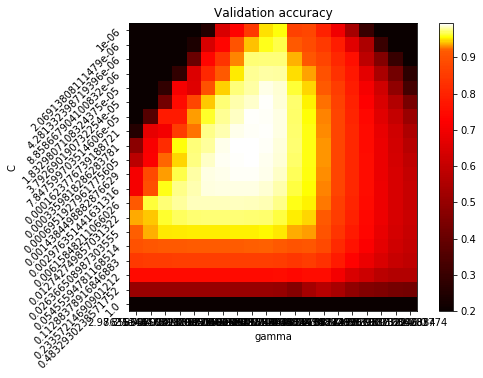

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
plt.figure(figsize=(8,5))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(fprateslist, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.yticks(np.arange(len(nus)), nus, rotation=45)
plt.xticks(np.arange(len(gammas)), gammas)
plt.title('Validation accuracy')
plt.show()

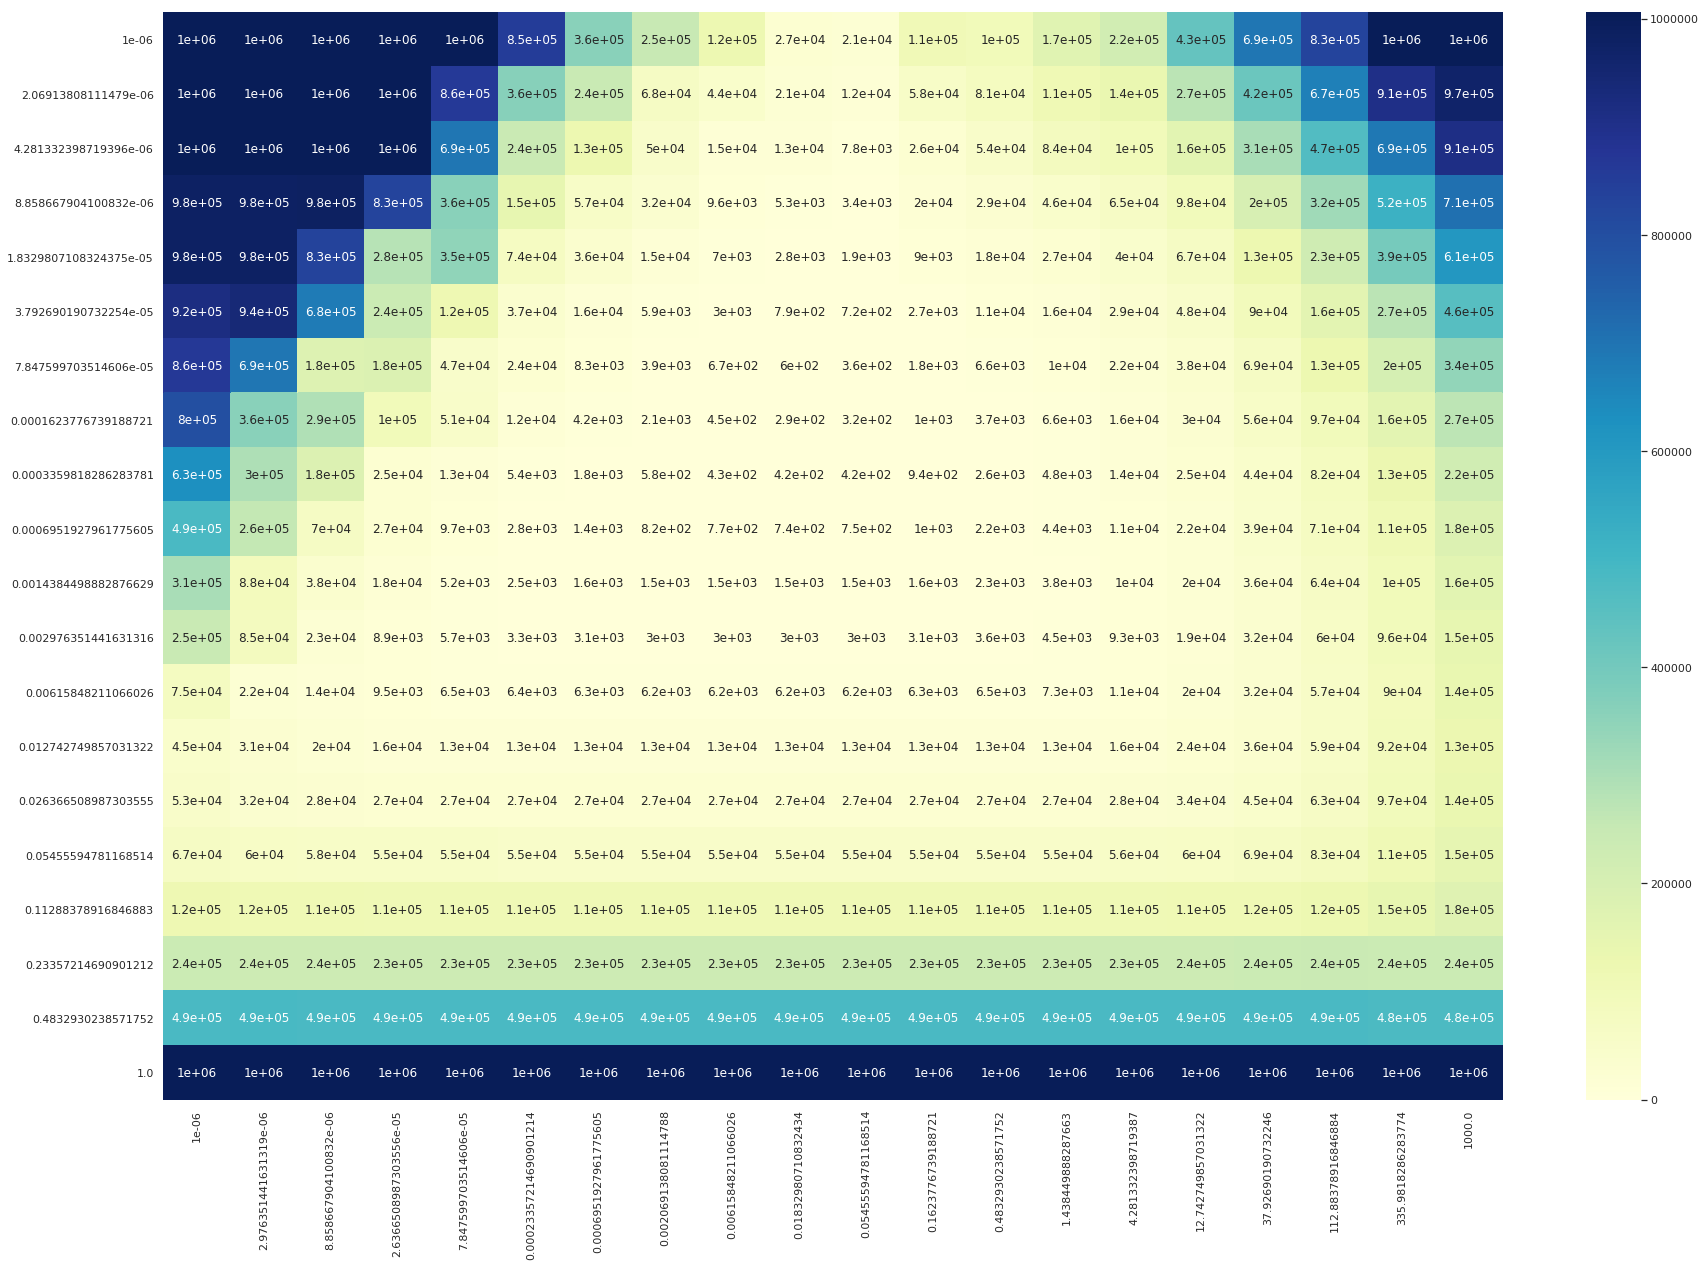

In [39]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(bfsizelist, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0, annot=True)

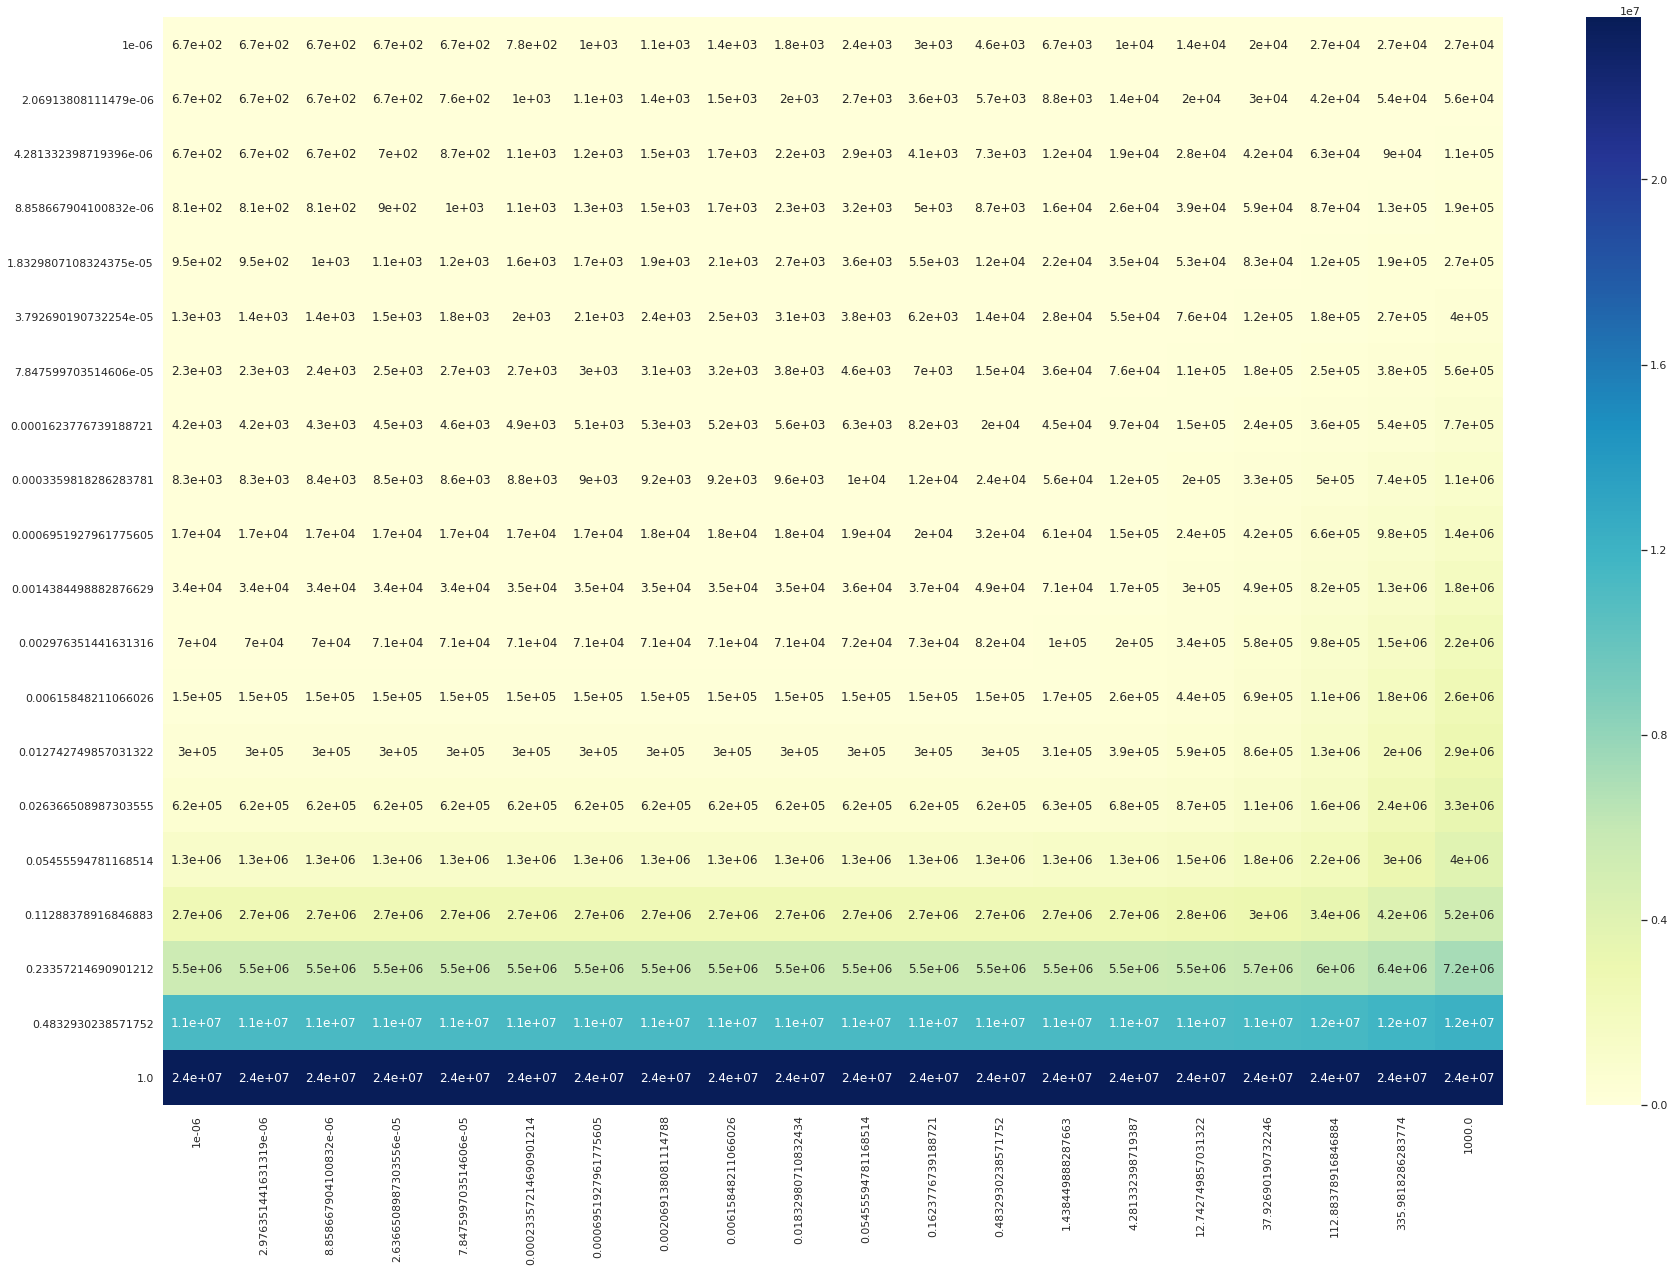

In [40]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(modelSizeList, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0, annot=True)

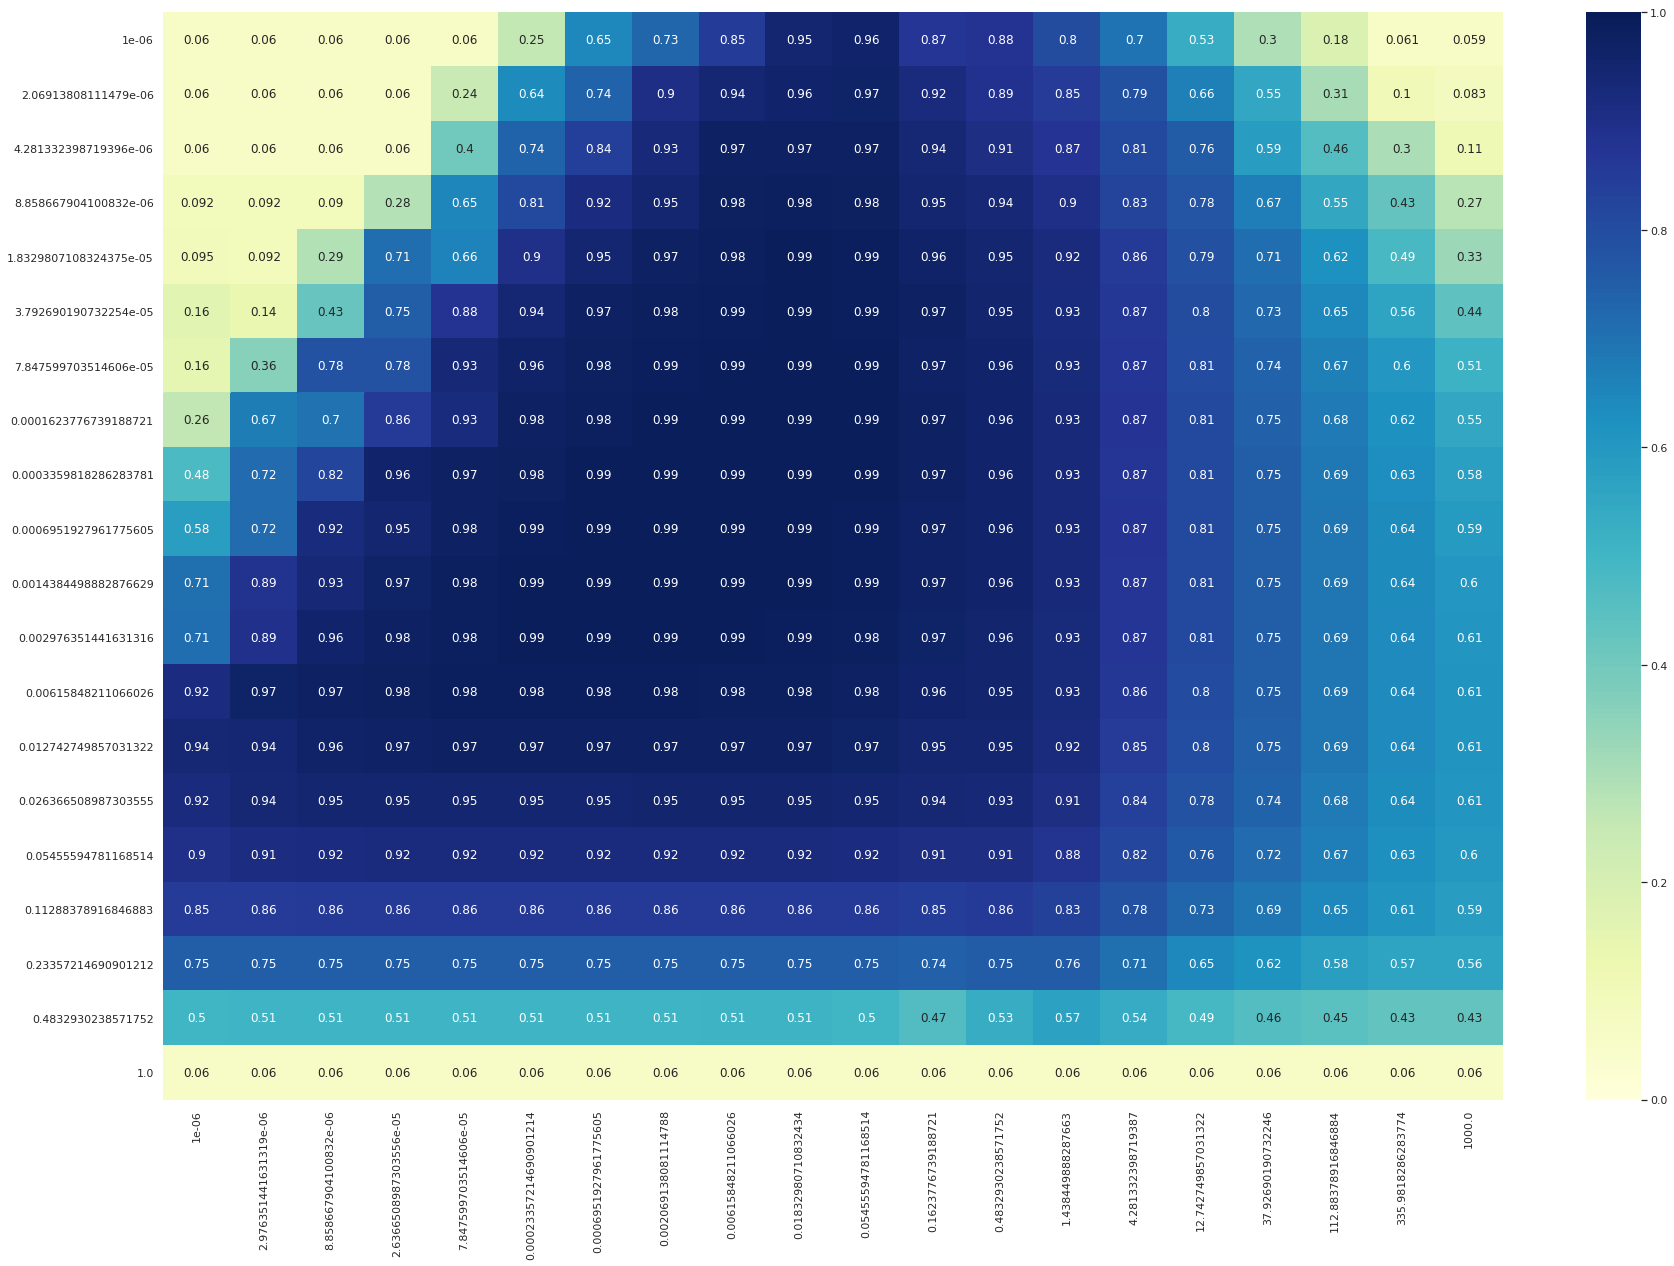

In [41]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(fprateslist, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0,vmax=1, annot=True)

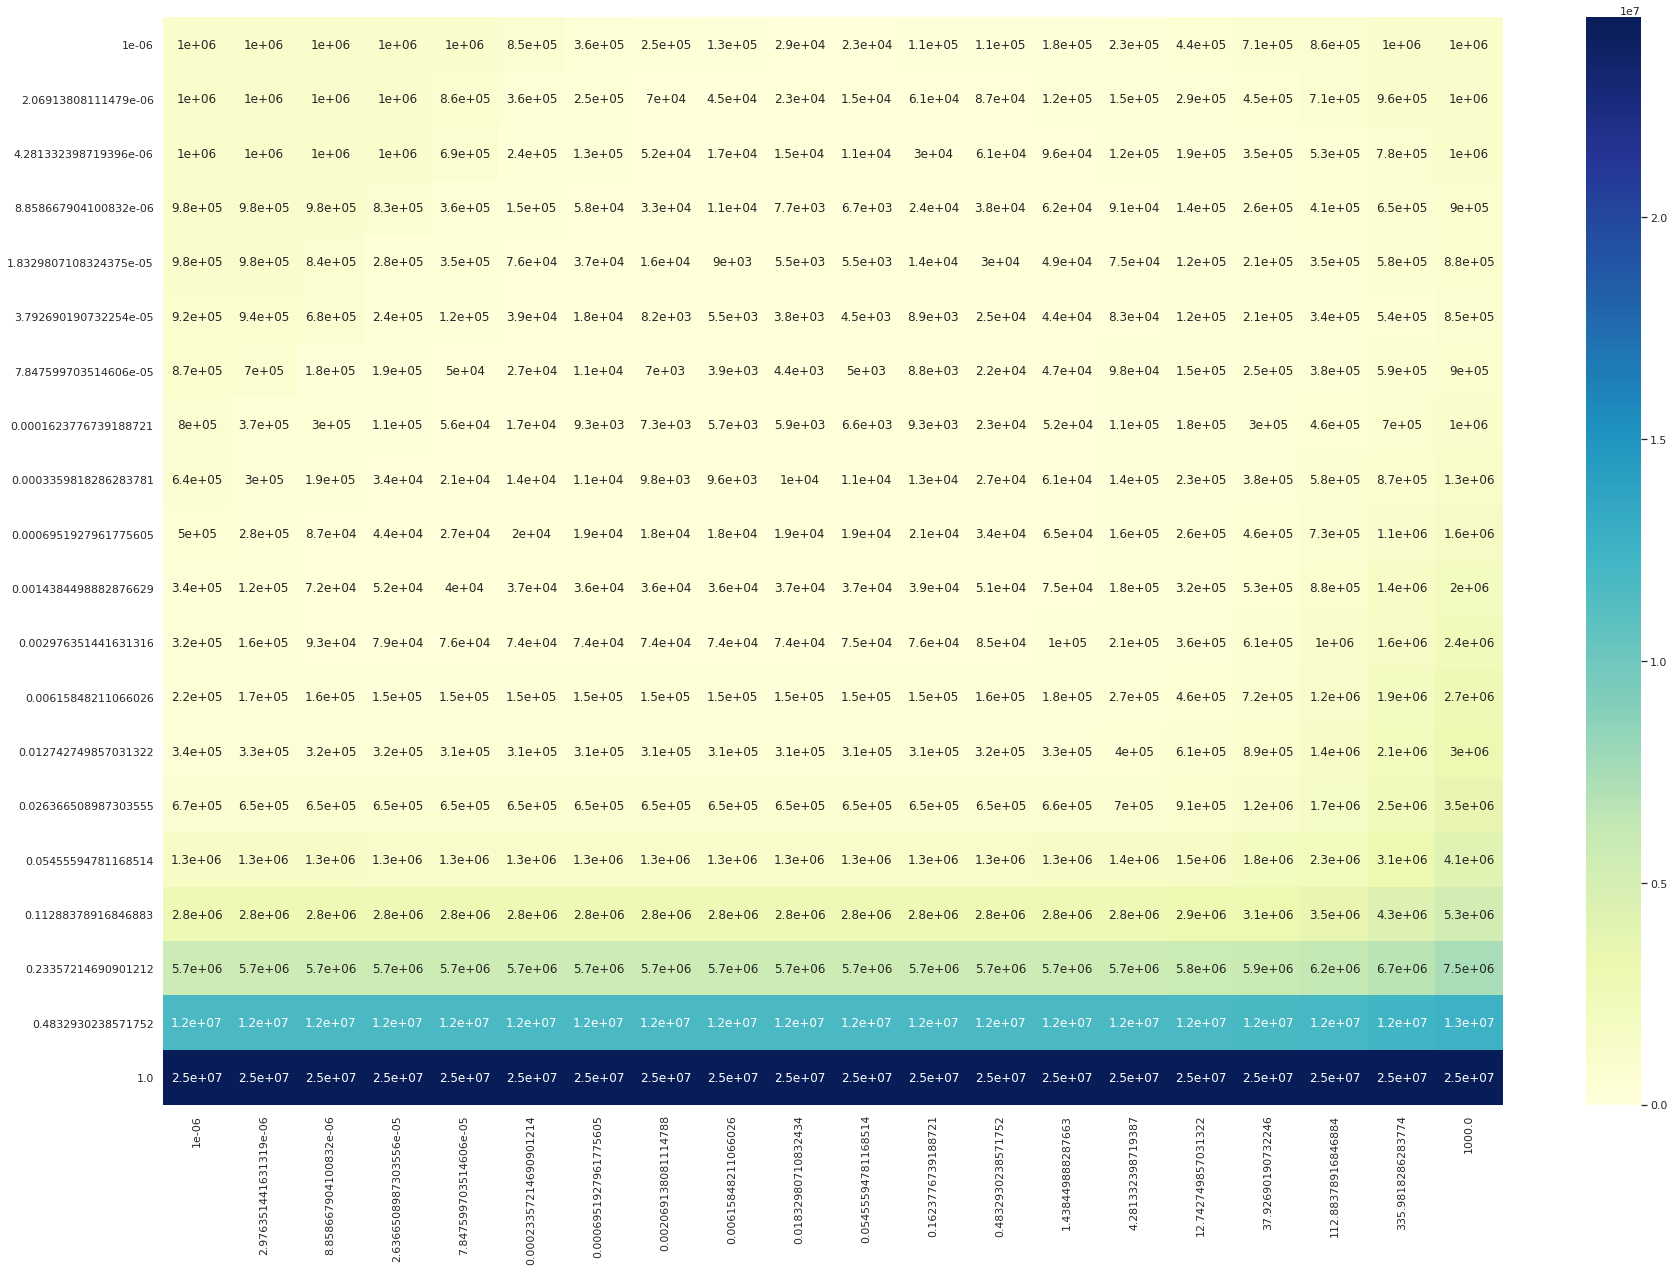

In [42]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(totalSizeList, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0, annot=True)

In [43]:
(fprateslist * bfsizelist).shape

(20, 20)

In [44]:
bestval = (fprateslist[0][0],totalSizeList[0][0])
bestpair = (0,0)
for i in range(20):
    for j in range(20):
        thisfpr = fprateslist[i][j]
        thismsize = totalSizeList[i][j]
        if(thisfpr<0.2 and thismsize<bestval[1]):
            bestval = (thisfpr,thismsize)
            bestpair = (i,j)
print(bestpair)
print(bestval) 
print(sumsizeofbloom(coreBf))
print(bestval[1]*1.0/sumsizeofbloom(coreBf)*1.0)
print(bestval[0]*1.0/coreobs[1])

(0, 17)
(0.18478639468144714, 856671)


NameError: name 'coreBf' is not defined

In [557]:
bestval = fprateslist[0][0]
bestpair = (0,0)
for i in range(20):
    for j in range(20):
        thisfpr = fprateslist[i][j]
        thismsize = totalSizeList[i][j]
        if(thisfpr<coreobs[1]):
            bestval = thisfpr
            bestpair = (i,j)
print(bestpair)
print(bestval) 
print(sumsizeofbloom(coreBf))
print(bestval*1.0/sumsizeofbloom(coreBf)*1.0)
print(bestval*1.0/coreobs[1])

(0, 19)
0.05931882543576696
1005675
5.898409072092571e-08
0.9964385652505724


In [551]:
coreobs[1]

0.059530840640285916

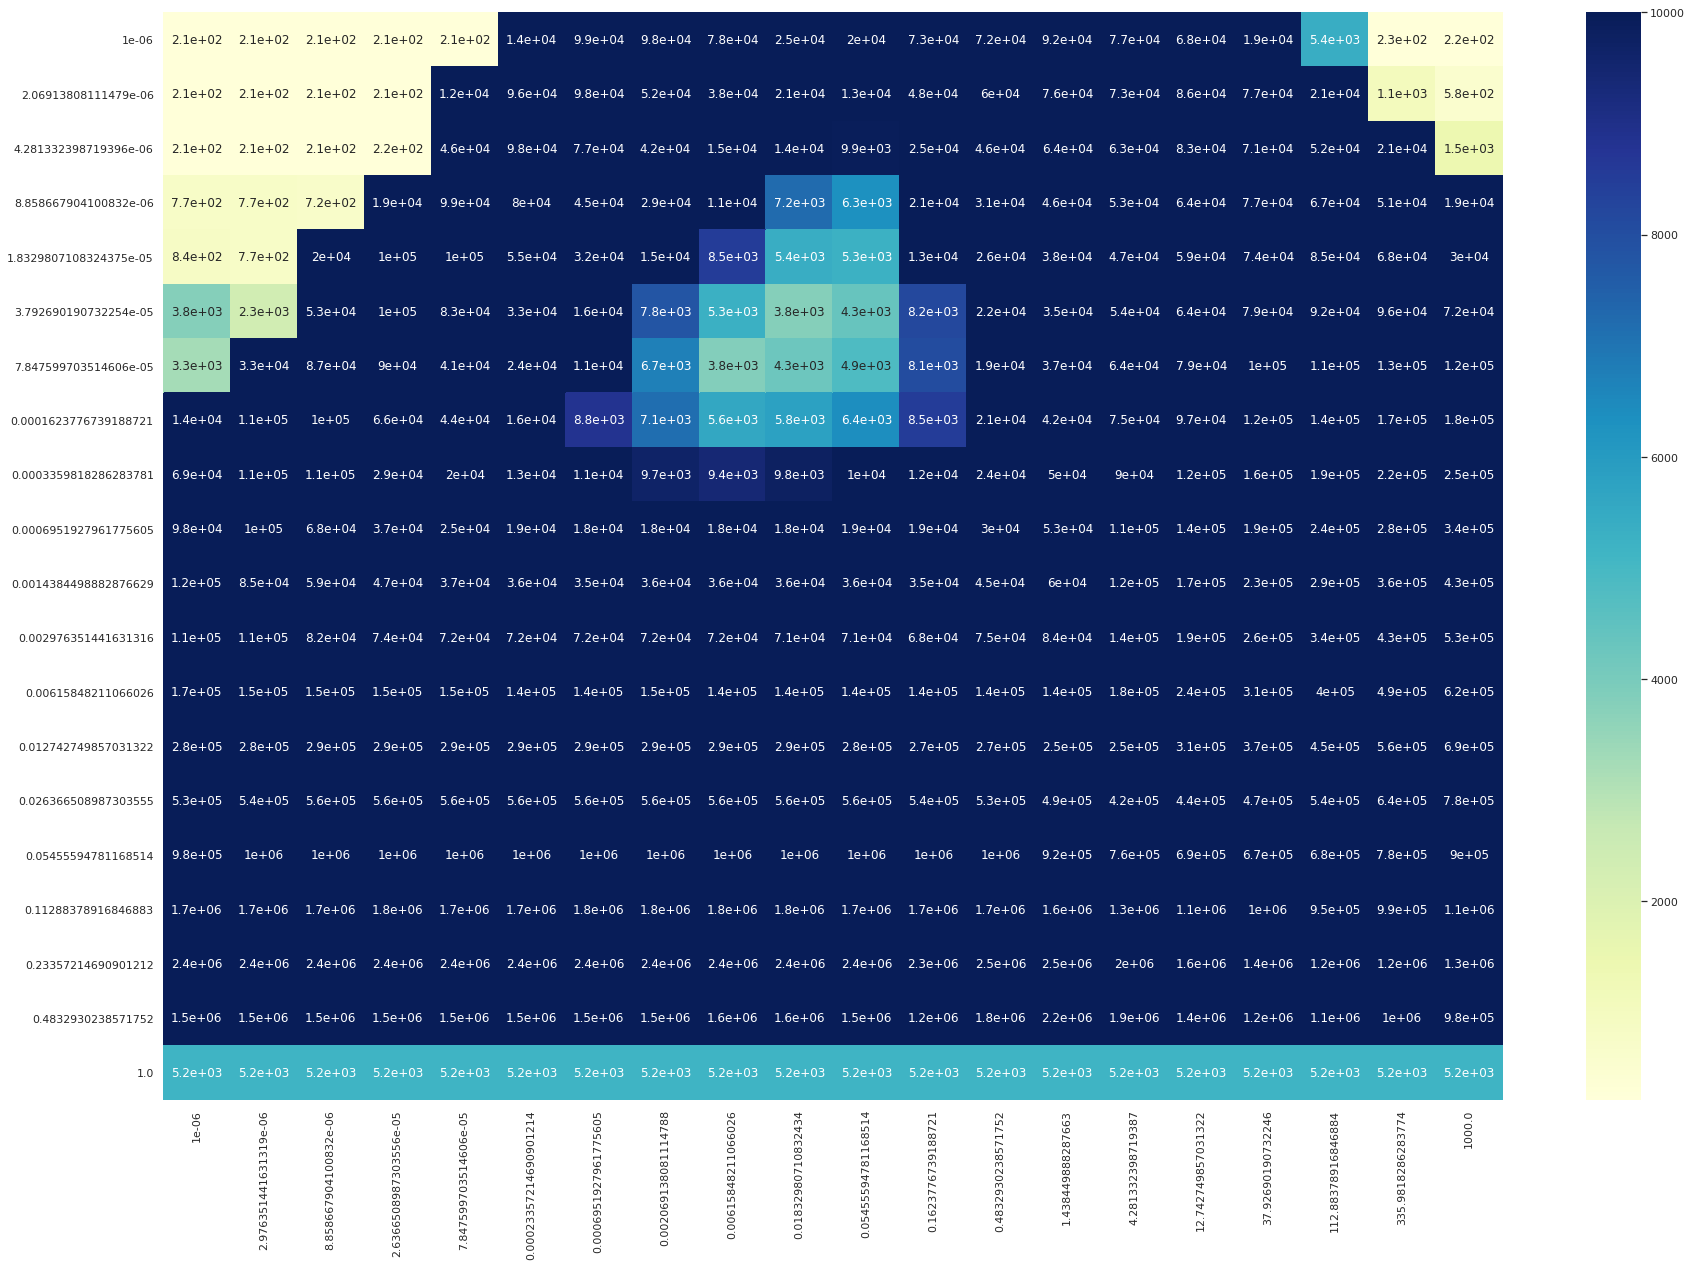

In [45]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap((np.power(fprateslist,3) * totalSizeList), xticklabels=gammas, yticklabels = nus, cmap="YlGnBu",vmax=1e4, annot=True)

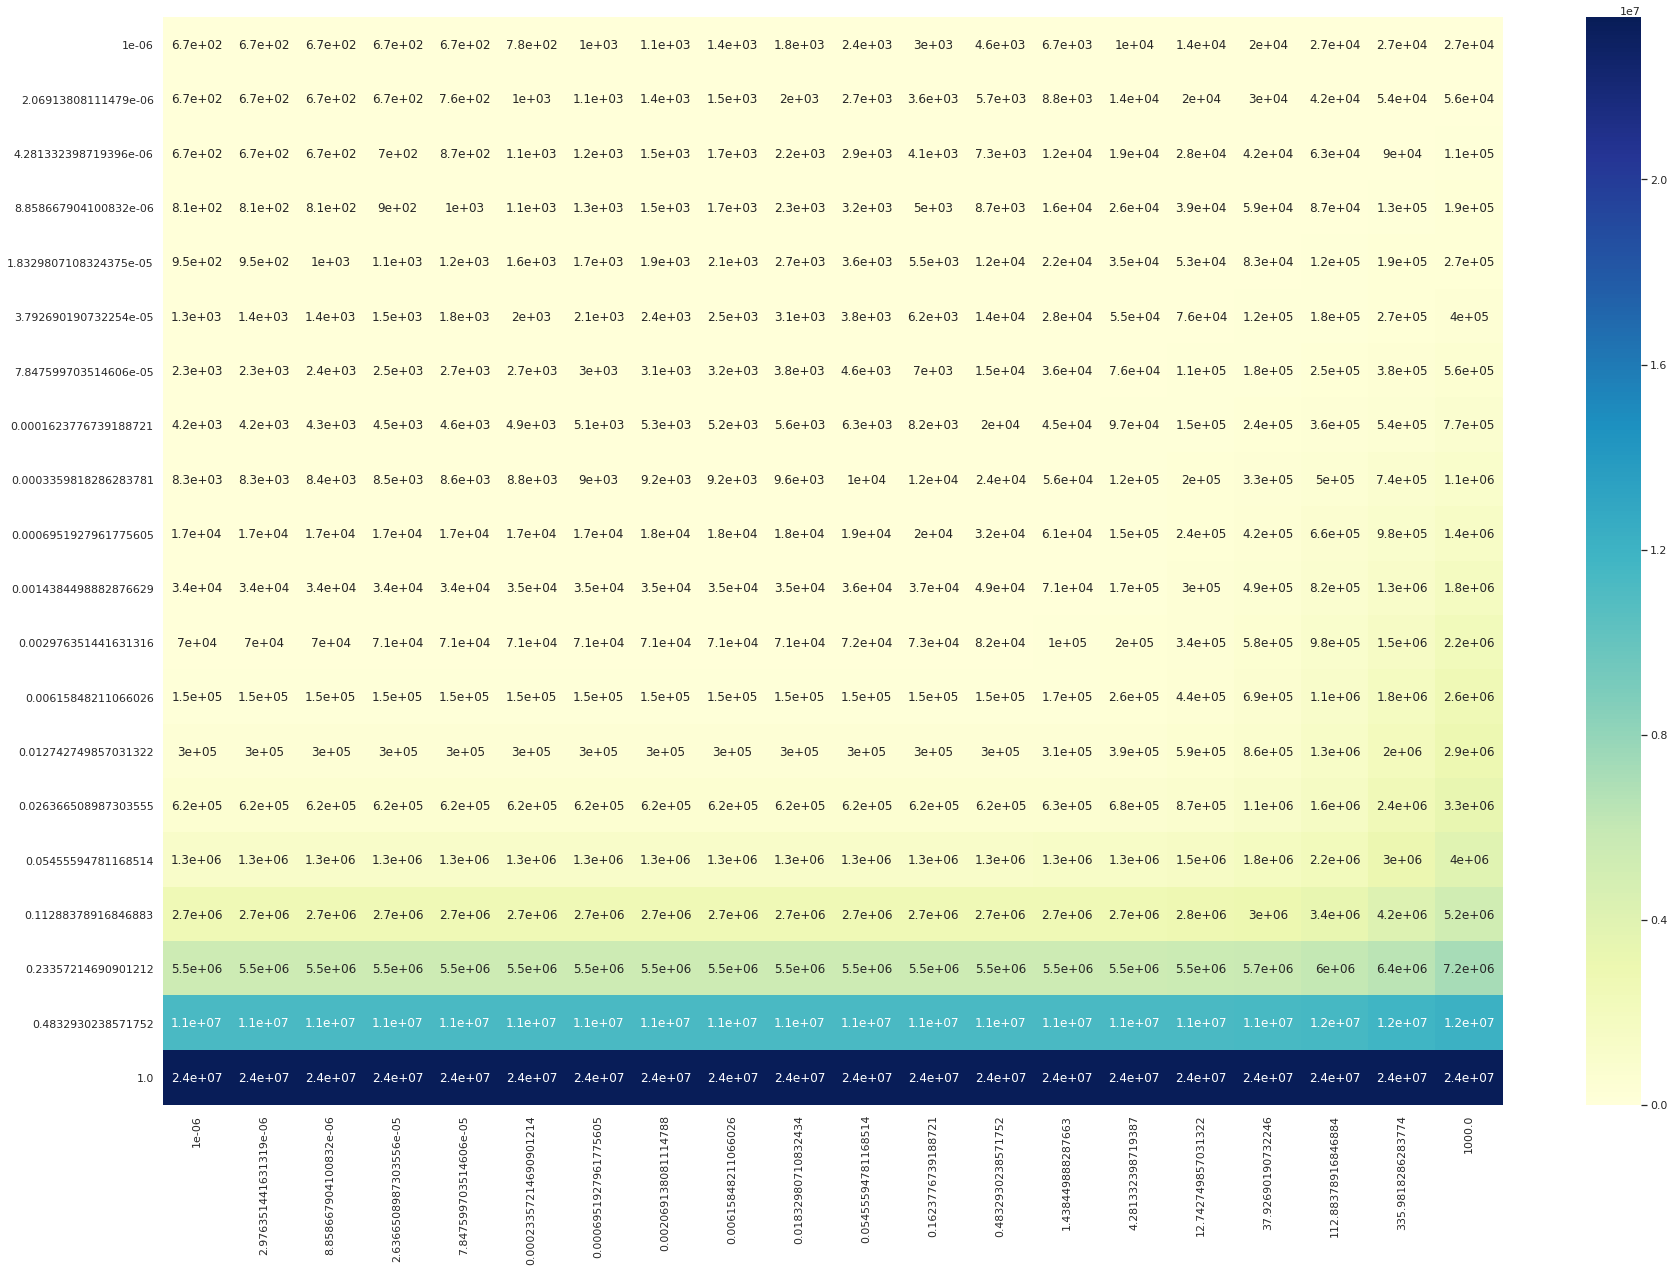

In [46]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(modelSizeList, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0, annot=True)

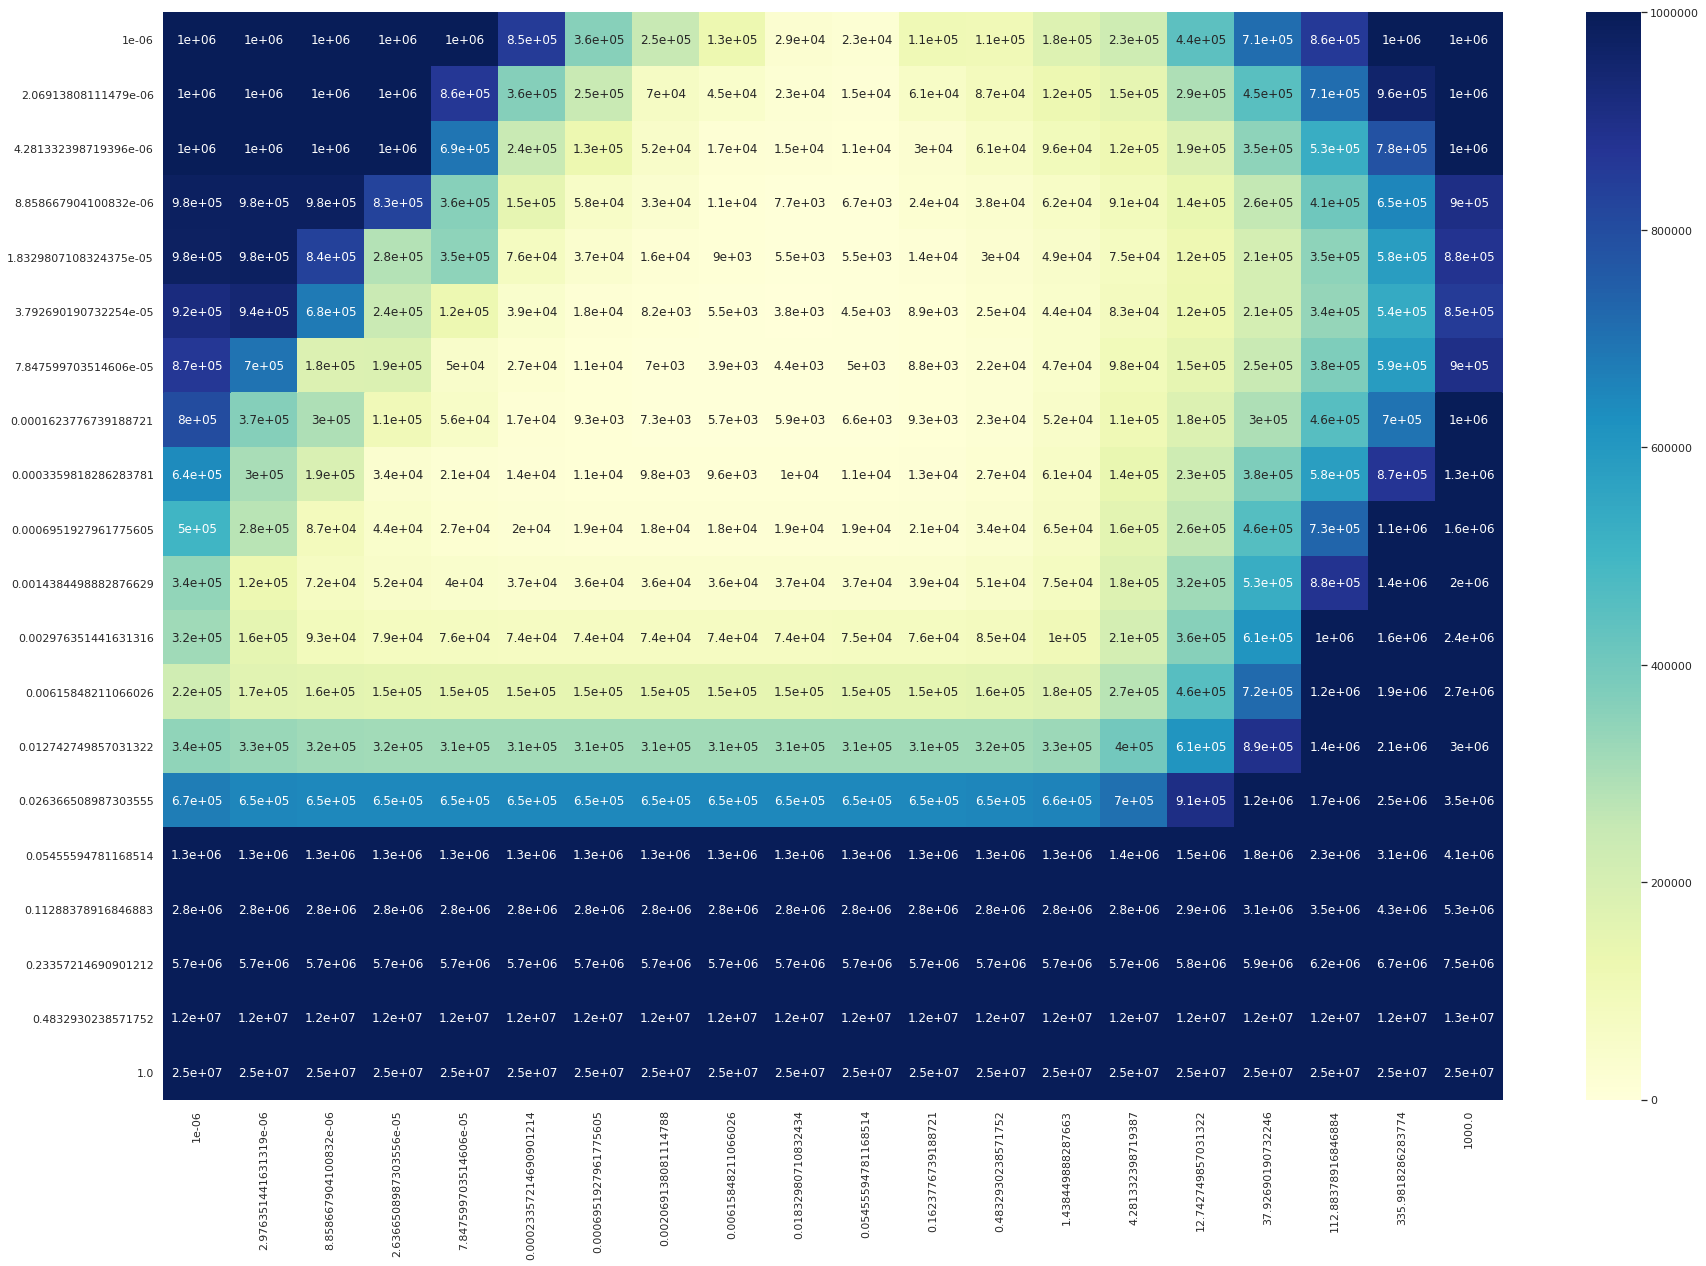

In [47]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(modelSizeList+bfsizelist, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0,vmax = 1e6, annot=True)

In [48]:
modelSizeList + bfsizelist*0

array([[     672,      672,      672,      672,      672,      784,
            1036,     1064,     1372,     1820,     2436,     3024,
            4592,     6692,    10276,    14000,    19712,    26936,
           26852,    26852],
       [     672,      672,      672,      672,      756,     1008,
            1064,     1400,     1512,     1960,     2744,     3556,
            5656,     8820,    13776,    19796,    30016,    42392,
           54012,    55832],
       [     672,      672,      672,      700,      868,     1064,
            1204,     1456,     1680,     2156,     2884,     4088,
            7252,    12012,    18844,    28000,    42392,    62860,
           90188,   112364],
       [     812,      812,      812,      896,     1036,     1148,
            1344,     1540,     1736,     2324,     3248,     4956,
            8680,    15792,    26152,    39480,    58576,    87472,
          132300,   193228],
       [     952,      952,     1008,     1148,     1232,     1568,


In [204]:
fpdic

{(1e-06, 1e-06): 0.059530840640285916,
 (1e-06, 2.976351441631319e-06): 0.059530840640285916,
 (1e-06, 8.858667904100832e-06): 0.059530840640285916,
 (1e-06, 2.6366508987303556e-05): 0.059530840640285916,
 (1e-06, 7.847599703514606e-05): 0.059530840640285916,
 (1e-06, 0.00023357214690901214): 0.25416079838868444,
 (1e-06, 0.0006951927961775605): 0.6483879272484969,
 (1e-06, 0.002069138081114788): 0.7313313040449472,
 (1e-06, 0.00615848211066026): 0.8515590689503733,
 (1e-06, 0.01832980710832434): 0.9499795556767071,
 (1e-06, 0.05455594781168514): 0.9580209895052474,
 (1e-06, 0.1623776739188721): 0.8672481940847758,
 (1e-06, 0.4832930238571752): 0.8760165371859525,
 (1e-06, 1.438449888287663): 0.8011903139339421,
 (1e-06, 4.281332398719387): 0.6966516741629185,
 (1e-06, 12.742749857031322): 0.5339451486378023,
 (1e-06, 37.92690190732246): 0.29660927112201474,
 (1e-06, 112.88378916846884): 0.18478639468144714,
 (1e-06, 335.9818286283774): 0.06078778792421971,
 (1e-06, 1000.0): 0.05931882

In [294]:
namePrefix = "core"
coreobs = loadObservations(0.1,1.0)
coreBf = loadBloomFilters(0.1,1.0)
print(sumsizeofbloom(coreBf))

1005675


In [206]:
coreobs

({0: 120691,
  1: 126781,
  2: 125351,
  3: 119538,
  4: 126719,
  5: 25367,
  6: 29100,
  7: 28898,
  8: 30806,
  9: 16550,
  10: 35023,
  11: 5815,
  12: 17015,
  13: 405,
  14: 4266,
  15: 1265,
  16: 16967,
  17: 1963,
  18: 880,
  19: 397,
  20: 1283,
  21: 845,
  22: 368,
  23: 3071},
 0.059530840640285916,
 0,
 16799,
 16799,
 0,
 3931,
 3931,
 62102)

In [57]:
nunumber = 16
gammanumber = 18
tempmodel = loadModel(nus[nunumber-1],gammas[gammanumber-1])
obs = loadObservations(nus[nunumber-1],gammas[gammanumber-1])
print(nus[nunumber-1],gammas[gammanumber-1])

(0.05455594781168514, 112.88378916846884)


In [50]:
namePrefix = '20nu20gamma'

In [241]:
tempmodel.fit_status_

0

In [242]:
tempmodel.offset_

array([191.05748477])

In [244]:
len(tempmodel.support_)

15527

In [245]:
tempmodel.support_

array([     0,    795,    796, ..., 120688, 120689, 120690], dtype=int32)

In [246]:
tempmodel.support_vectors_

array([[ 0.40930624, -0.92512876],
       [-0.24446319, -0.95669717],
       [-0.24446319, -0.95532463],
       ...,
       [ 0.91068776,  0.44466575],
       [ 0.91068776,  0.44603829],
       [ 0.91068776,  0.44741083]])

In [257]:
len(set(tempmodel.dual_coef_[0]))

4067

In [258]:
len(tempmodel.dual_coef_[0])

15527

In [260]:
tempmodel.dual_coef_[0].tolist().count(1.0)

11461

In [262]:
tempmodel?

In [263]:
tempmodel.intercept_

array([-191.05748477])

In [265]:
type(tempmodel.support_)

numpy.ndarray

In [268]:
tempmodel.support_.dtype

dtype('int32')

In [269]:
tempmodel.support_vectors_.dtype

dtype('float64')

In [270]:
tempmodel.dual_coef_.dtype

dtype('float64')

In [272]:
tempmodel.intercept_

array([-191.05748477])

In [280]:
8*(tempmodel.support_vectors_.shape[0]*tempmodel.support_vectors_.shape[1])+ 8*(tempmodel.dual_coef_.shape[0]*tempmodel.dual_coef_.shape[1]) + 4*(tempmodel.support_.shape[0])

434756

In [279]:
tempmodel.support_.shape[0]

15527

In [283]:
sumsizeofmodelssvmReal(models)

('20', 35924)
('21', 23660)
('22', 10304)
('23', 85988)
('1', 3549868)
('0', 3379348)
('3', 3347064)
('2', 3509828)
('5', 710276)
('4', 3548132)
('7', 809144)
('6', 814800)
('9', 463400)
('8', 862568)
('11', 162820)
('10', 980644)
('13', 11340)
('12', 476420)
('15', 35420)
('14', 119448)
('17', 54964)
('16', 475076)
('19', 11116)
('18', 24640)


23502192

In [521]:
# nunumber = 18
# gammanumber = 18
# # tempmodel = loadModel(nus[nunumber-1],gammas[gammanumber-1])
# tempmodel = trainFnTol(nus[nunumber-1],gammas[gammanumber-1],1e-5)
# print(nus[nunumber-1],gammas[gammanumber-1])

('passed mean was ', array([-5.07181625e-15,  2.27895558e-16]))
('passed sigma was ', array([1., 1.]))
('training done with sstableid - ', 0)
('0.23357214690901212', '112.88378916846884', 'time taken ', 372.65777802467346)
('passed mean was ', array([-3.17012323e-15, -3.70918226e-16]))
('passed sigma was ', array([1., 1.]))
('training done with sstableid - ', 1)
('0.23357214690901212', '112.88378916846884', 'time taken ', 367.11824107170105)
('passed mean was ', array([ 9.77059323e-15, -2.30447159e-16]))
('passed sigma was ', array([1., 1.]))
('training done with sstableid - ', 2)
('0.23357214690901212', '112.88378916846884', 'time taken ', 440.3717210292816)
('passed mean was ', array([ 9.34875809e-15, -5.20025221e-17]))
('passed sigma was ', array([1., 1.]))
('training done with sstableid - ', 3)
('0.23357214690901212', '112.88378916846884', 'time taken ', 264.8125078678131)
('passed mean was ', array([8.80621624e-15, 1.56181760e-16]))
('passed sigma was ', array([1., 1.]))
('trainin

In [522]:
# namePrefix = namePrefix + "tol1e-5"
# persistModel(tempmodel,nus[nunumber-1],gammas[gammanumber-1])

In [51]:
ssTableNumber = 2
temptableData = ssTableData[ssTableNumber]
clf = tempmodel[str(ssTableNumber)][0]
xx, yy = np.meshgrid(
    np.linspace(
        min(scalers[ssTableNumber].transform(temptableData.reshape(-1,2)).T[0]), 
        max(scalers[ssTableNumber].transform(temptableData.reshape(-1,2)).T[0]), 500), 
    np.linspace(
        min(scalers[ssTableNumber].transform(temptableData.reshape(-1,2)).T[1]), 
        max(scalers[ssTableNumber].transform(temptableData.reshape(-1,2)).T[1]), 500))
Z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape(xx.shape)
thisScaleddata = scalers[ssTableNumber].transform(temptableData)
thistablepredicitons = clf.predict(thisScaleddata)



In [52]:
testData = []
for i in range(len(ssTableData)):
    if i==ssTableNumber:
        continue
    thistabledata = ssTableData[i]
    for j in range(0, len(thistabledata), skipFactor):
        testData.append(thistabledata[j])
testData = np.array(testData)

In [53]:
testScaleddata = scalers[ssTableNumber].transform(testData)
testtablepredicitons = clf.predict(testScaleddata)

In [54]:
errorTestCases = np.array([testScaleddata[i] for i in range(len(testScaleddata)) if testtablepredicitons[i]==1])

In [55]:
errorTrainCases = np.array([thisScaleddata[i] for i in range(len(thisScaleddata)) if thistablepredicitons[i]==-1 ])

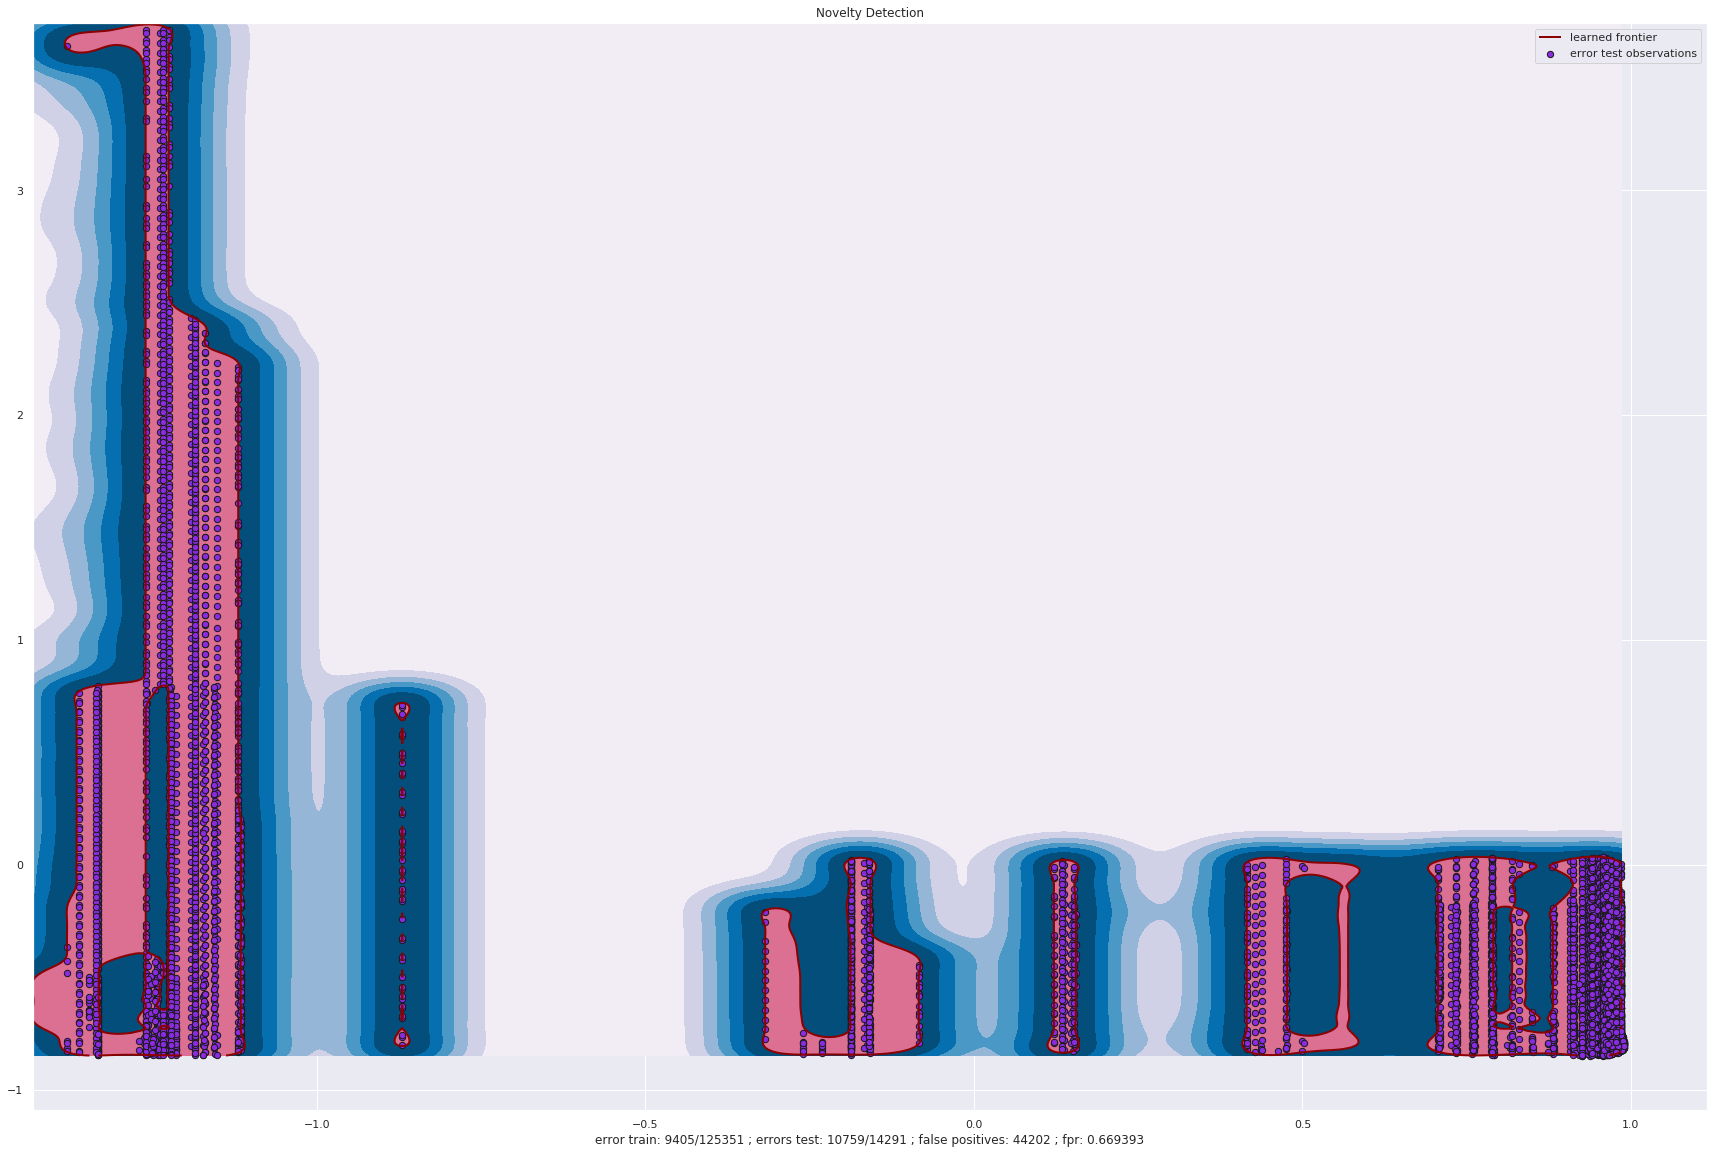

In [62]:

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
s = 40

# testData = np.array([ssTableData[i] for i in ssTableData if i!=ssTableNumber]).reshape(-1,2)
b2 = plt.scatter(errorTestCases[:, 0], errorTestCases[:, 1], c='blueviolet', s=s, edgecolors='k')
# b1 = plt.scatter(
#     scalers[ssTableNumber].transform(ssTableData[ssTableNumber])[:, 0], 
#     scalers[ssTableNumber].transform(ssTableData[ssTableNumber])[:, 1], c='white', s=s, edgecolors='k')
# b3 = plt.scatter(errorTrainCases[:,0], errorTrainCases[:,1], c='yellow', s=s, edgecolors='k')
# b4 = plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c= 'green', s=s, edgecolors='k')
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 0]*0+2, c='gold', s=s,
#                 edgecolors='k')
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.show()
plt.legend([a.collections[0], b2],
           ["learned frontier", "error test observations"],
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/%d ; errors test: %d/%d ; false positives: %d ; fpr: %f"
    % (len(errorTrainCases), len(thisScaleddata), len(errorTestCases), len(testScaleddata), obs[7], obs[1]))
plt.show()


In [389]:
plt.savefig("plots/"+namePrefix + str(nus[nunumber-1])+"_"+str(gammas[gammanumber-1]) +"_"+ str(ssTableNumber) +"_"+ str(nunumber)+"_"+str(gammanumber)+".png")


<Figure size 2160x1440 with 0 Axes>

In [418]:

errorTrainCases =  np.array(errorTrainCases)

In [401]:
map(scalers[0].transform, ssTableData[0])

ValueError: Expected 2D array, got 1D array instead:
array=[1.38071126e+09 2.94400000e+03].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [412]:
thisScaleddata = scalers[ssTableNumber].transform(temptableData)
thistablepredicitons = clf.predict(thisScaleddata)
[thisScaleddata[i] for i in range(len(thisScaleddata)) if thistablepredicitons[i]==-1]

[array([ 0.15533484, -0.82213733]),
 array([ 0.15533484, -0.81954494]),
 array([ 0.15533484, -0.81868081]),
 array([ 0.15533484, -0.81695255]),
 array([ 0.15533484, -0.81522428]),
 array([ 0.15533484, -0.81349602]),
 array([ 0.15533484, -0.80917536]),
 array([ 0.15533484, -0.80831123]),
 array([ 0.15533484, -0.8074471 ]),
 array([ 0.15533484, -0.80658297]),
 array([ 0.15533484, -0.80485471]),
 array([ 0.15533484, -0.80312644]),
 array([ 0.15533484, -0.79966992]),
 array([ 0.15533484, -0.79448513]),
 array([ 0.15533484, -0.79275687]),
 array([ 0.15533484, -0.79189274]),
 array([ 0.15533484, -0.78670795]),
 array([ 0.15533484, -0.78497968]),
 array([ 0.15533484, -0.78325142]),
 array([ 0.15533484, -0.78238729]),
 array([ 0.15533484, -0.77374598]),
 array([ 0.15533484, -0.77201771]),
 array([ 0.15533484, -0.77115358]),
 array([ 0.15533484, -0.76856119]),
 array([ 0.15533484, -0.76769706]),
 array([ 0.15533484, -0.76683293]),
 array([ 0.15533484, -0.76078401]),
 array([ 0.15533484, -0.7581

In [410]:
thistablepredicitons.tolist().count(-1)

31434

In [409]:
thistablepredicitons.tolist().count(1)

93917

In [421]:
np.linspace(Z.min(), 0, 7)

array([-303.79998425, -253.16665354, -202.53332283, -151.89999213,
       -101.26666142,  -50.63333071,    0.        ])

In [422]:
Z.max()

36.62876040263518

In [428]:
clf.get_params()

{'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'gamma': 112.88378916846884,
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.23357214690901212,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [444]:
tempscores = clf.score_samples(thisScaleddata)

In [464]:
wrongscores = [tempscores[i] for i in range(len(thisScaleddata)) if thistablepredicitons[i]==-1]

In [534]:
min(wrongscores)

40.37965218412211

In [535]:
max(wrongscores)

303.79998410649733

In [438]:
tempscores = tempscores.tolist()


AttributeError: 'list' object has no attribute 'tolist'

In [442]:
tempscores.sort(reverse=True)

In [443]:
tempscores

[339.1042253359518,
 339.10409529997594,
 339.1007040085493,
 339.1002531051355,
 339.0935930818227,
 339.0926389958659,
 339.08295521703513,
 339.0811943277833,
 339.0688539013883,
 339.0658616387491,
 339.05135337693474,
 339.04658471965126,
 339.0305185697674,
 339.02330868479896,
 339.0064150195654,
 338.99598004184315,
 338.9791088095962,
 338.9645467611236,
 338.948666497258,
 338.92895834434427,
 338.9151550452446,
 338.8891658924937,
 338.87864175342344,
 338.84512217289426,
 338.83919419150044,
 338.796880132561,
 338.7967816853157,
 338.75176748756166,
 338.74410072703074,
 338.7039242408447,
 338.68703745674213,
 338.65341838675835,
 338.6255519572743,
 338.60031786744554,
 338.55960629695056,
 338.5446905118731,
 338.4891645895657,
 338.4866039761738,
 338.42612568535446,
 338.4141930528564,
 338.3633227764372,
 338.33466006539686,
 338.29826204309717,
 338.2505362218283,
 338.2310098818381,
 338.16179438634106,
 338.1616322397722,
 338.09019456404656,
 338.06840974433305,


In [441]:
clf.intercept_

array([-303.79998425])

In [536]:
np.sort(wrongscores + clf.intercept_[0])

array([-2.63420281e+02, -2.56480785e+02, -2.55862817e+02, ...,
        5.03446726e-05,  5.04151711e-05,  5.04324853e-05])

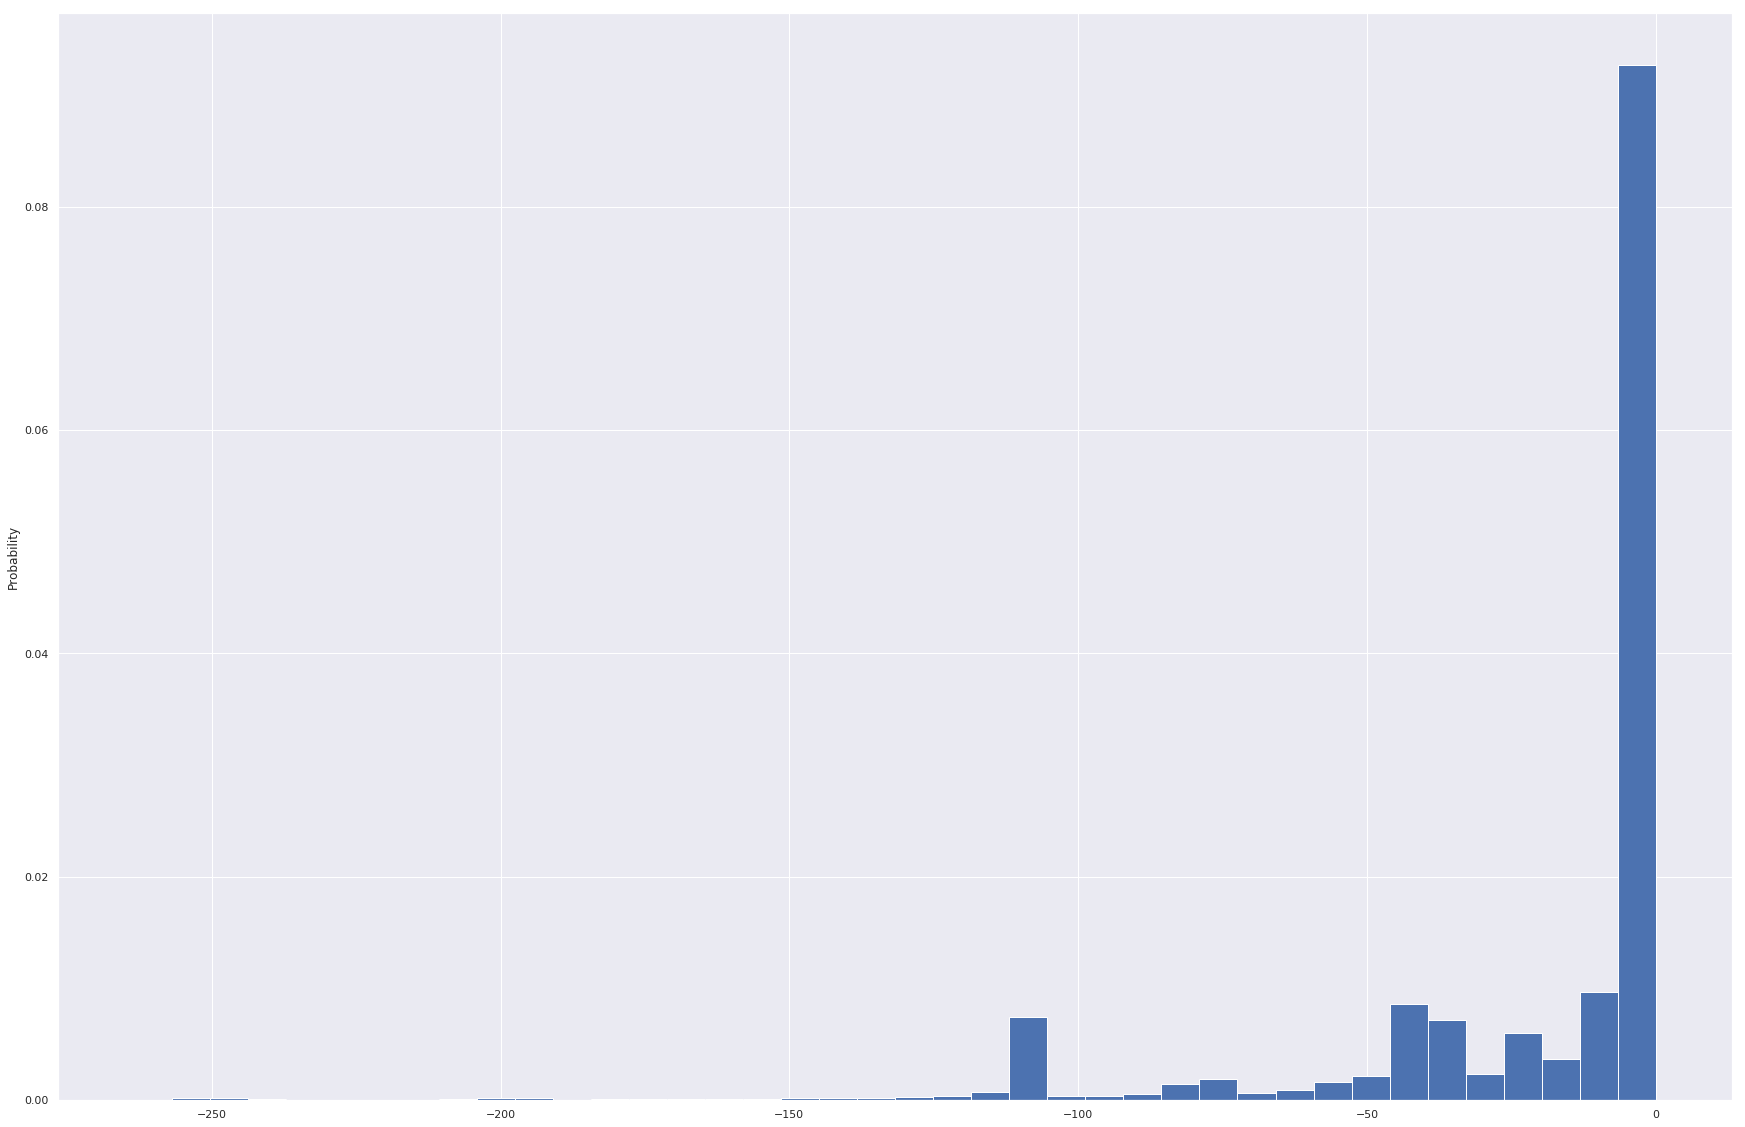

In [537]:
plt.hist(np.sort(wrongscores + clf.intercept_[0]), normed=True, bins=40)
plt.ylabel('Probability');

In [460]:
np.sort(tempscores)

array([ 40.37965218,  47.3191486 ,  47.93711647, ..., 339.10070401,
       339.1040953 , 339.10422534])

In [461]:
tempscores

array([325.97799123, 318.72333663, 318.73856729, ..., 306.52050224,
       306.5372535 , 306.55434565])

In [463]:
errorTrainCases

array([[ 0.15533484, -0.82213733],
       [ 0.15533484, -0.81954494],
       [ 0.15533484, -0.81868081],
       ...,
       [ 0.91274076, -0.83941996],
       [-1.34659354, -0.84633301],
       [-1.34659354, -0.84374062]])

In [492]:
wrongscores

[241.58734158497137,
 245.8946048167717,
 247.2968412448172,
 250.04974704752703,
 252.73258186298793,
 255.34389523393938,
 261.5510987237813,
 262.7364414231403,
 263.9028273227376,
 265.0501654556647,
 267.28738322250246,
 269.44756175522383,
 273.53544748138216,
 279.0850689386241,
 280.78047364588815,
 281.59945878815006,
 286.116862398607,
 287.4742777996662,
 288.75927574706947,
 289.3750037401181,
 294.5936014651464,
 295.4430937531638,
 295.84500937367585,
 296.96233625811726,
 297.3061346251119,
 297.6360347447993,
 299.5782919604297,
 300.2289057523665,
 300.4235552456466,
 301.9231124271998,
 302.0082872751418,
 302.08611534813883,
 302.1568621405766,
 302.3292329027961,
 302.54789127193004,
 302.5457384859092,
 302.54011021653605,
 302.50443921154596,
 302.4869525668456,
 302.44473329096417,
 302.42036648687036,
 302.36599593825724,
 302.1333435431532,
 302.02208594575643,
 301.5824037291888,
 301.3955802067338,
 301.26719126444146,
 301.18441284753,
 301.0456641838749,
 3

In [476]:
clf.support_vectors_

array([[ 0.15533484, -0.82213733],
       [ 0.15533484, -0.81954494],
       [ 0.15533484, -0.81868081],
       ...,
       [ 0.91274076, -0.83941996],
       [-1.34659354, -0.84633301],
       [-1.34659354, -0.84374062]])

In [483]:
scoressup = clf.score_samples(clf.support_vectors_)
predictionssup = clf.predict(clf.support_vectors_)

In [499]:
np.sort(scoressup+clf.intercept_[0])[-15000:]

array([-0.35398374, -0.35393367, -0.35339268, ...,  0.00048505,
        0.00048971,  0.00049508])

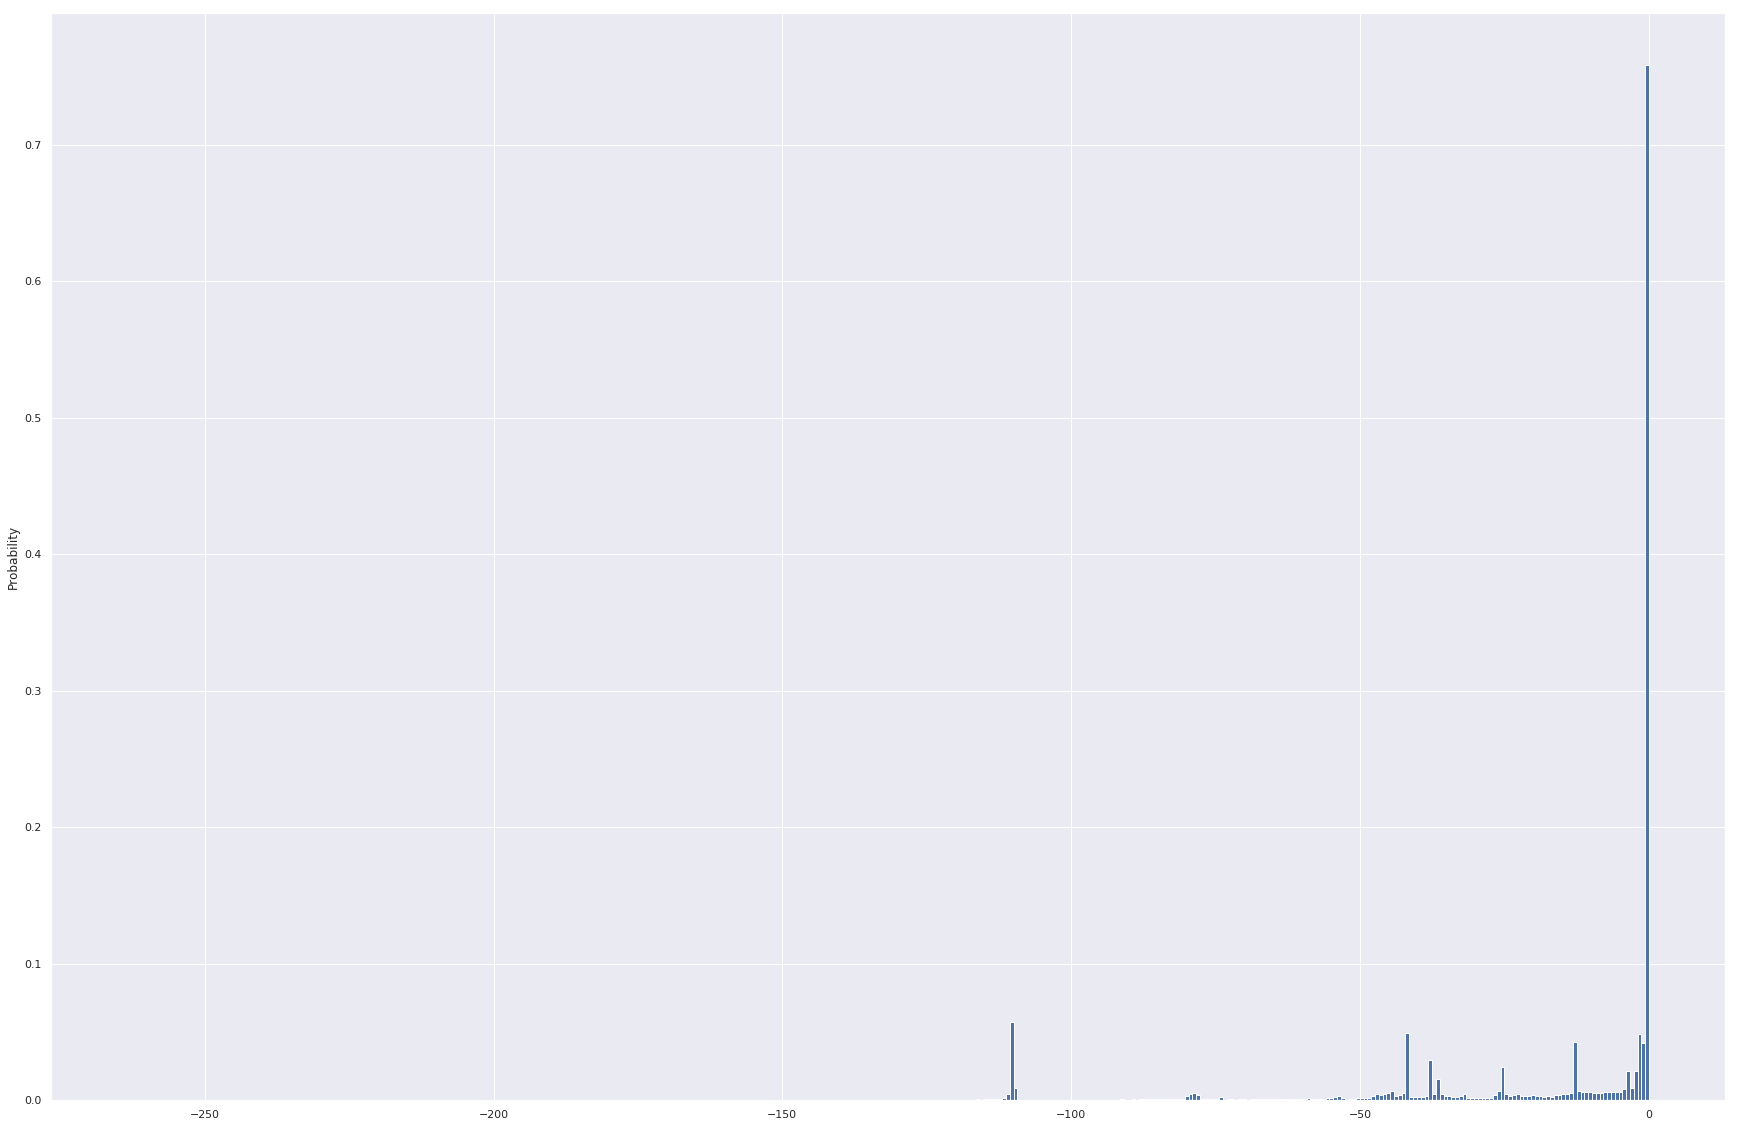

In [491]:
plt.hist(np.sort(scoressup+clf.intercept_[0]), normed=True, bins=400)
plt.ylabel('Probability');

In [538]:
clf.tol

1e-05

In [497]:
len(scoressup)

31452

In [1]:
#!/usr/bin/env python3

import numpy as np
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.metrics import accuracy_score


class RPEOCC(BaseEstimator, ClassifierMixin):
    def __init__(self, D, epsilon, agg_thr=1, box_thr=0, agg_abs=None):
        self.D = D
        self.epsilon = epsilon
        self.agg_thr = agg_thr
        self.agg_abs = agg_abs
        self.box_thr = box_thr

    def fit(self, x):
        # generate D unit vectors
        self.feature_len = len(x[0])
        rng = np.random.RandomState(seed=42)
        planes = rng.uniform(low=-1, size=(self.D, self.feature_len))
        mags = np.sqrt((planes * planes).sum(axis=-1)).reshape(-1, 1)
        planes = planes / mags
        self.planes = planes

        self.box_thr = len(x) * self.box_thr

        # dot them with each dimention
        projections = x.dot(planes.T)  # shape should be NxD

        # take epsilon separated intervals in each dimension

        ## sort each dimension
        projections = np.sort(projections, axis=0)

        # list of length D. each entry is a list of tuples representing interval start and end
        self.intervals = [
            get_intervals(projections[:, d], self.epsilon, self.box_thr)
            for d in range(self.D)
        ]

        # self.intervals = filter_intervals(projections, self.intervals, self.box_thr)

        return self

    def decision_function(self, x):
        # get the projections
        projections = x.dot(self.planes.T)

        scores = []
        for v in projections:
            pred_sum = 0
            for d in range(self.D):
                if in_interval(self.intervals[d], v[d]):
                    pred_sum += 1
            scores.append(pred_sum / self.D)
        return np.array(scores)

    def predict(self, x):
        # get the projections
        projections = x.dot(self.planes.T)

        predictions = []
        for v in projections:
            pred_sum = 0
            for d in range(self.D):
                if in_interval(self.intervals[d], v[d]):
                    pred_sum += 1
            if not self.agg_abs:
                if pred_sum >= self.D * self.agg_thr:
                    predictions.append(1)
                else:
                    predictions.append(-1)
            elif (self.D - pred_sum) < self.agg_abs:
                predictions.append(1)
            else:
                predictions.append(-1)
        return np.array(predictions)

    def score(self, x, y):
        preds = self.predict(x)
        return accuracy_score(preds, y)

    def get_params(self, deep=None):
        return {
            "D": self.D,
            "epsilon": self.epsilon,
            "agg_thr": self.agg_thr,
            "agg_abs": self.agg_abs,
            "box_thr": self.box_thr,
        }

    def set_params(self, **params):
        self.D = params["D"]
        self.epsilon = params["epsilon"]
        if "agg_thr" in params.keys():
            self.agg_thr = params["agg_thr"]
        if "agg_abs" in params.keys():
            self.agg_abs = params["agg_abs"]
        if "box_thr" in params.keys():
            self.box_thr = params["box_thr"]

    def get_size(self):
        plane_size = self.planes.shape[0] * self.planes.shape[0]
        interval_size = self.intervals.shape[0] * self.intervals.shape[0]
        return (plane_size + interval_size) * 64


def get_intervals(l, epsilon, box_thr):
    """ Returns a list of (start, end) tuples of intervals"""
    intervals = []
    start = l[0]
    end = l[0]

    count = 0
    epsilon = (np.max(l) - np.min(l)) * epsilon

    for e in l[1:]:
        if e < end + epsilon:
            end = e
            count += 1
        else:
            if count >= box_thr:
                intervals.append((start, end))
            count = 0
            start = e
            end = e
    else:
        if count >= box_thr:
            intervals.append((start, end))
        count = 0

    return intervals


def in_interval(intervals, val):
    for start, end in intervals:
        if start <= val <= end:
            return True
    else:
        return False


In [ ]:
ssTa